The sea ice response to the storm system included variation in drift direction and speed at the scale of the storm (large-scale response) as well as motion at smaller scales, include shear and divergence. The sea ice response will be summarized using time series of velocity, color-coded by buoy groups, maps showing the drift directions and wind directions at specific times during the storm, and time series with divergence and shear estimates for strategically selected groups of buoys. At the smaller scale, we will see a coherent picture of a passing front through the timing of the minimum drift speed and maximum change in direction. There are many questions to answer and we can't necessarily answer them all. Some key questions: 
- What is the "net effect" of the storm for displacement? What would be seen by satellite?
- Are the shear zones aligned with the wind forcing, or related to existing fractures?
- Is the larger scale motion reflective of rotation from the storm?

In [10]:
import cartopy.crs as ccrs
import pandas as pd
import numpy as np
import os
import proplot as pplt
import pyproj
import sys
sys.path.append('../scripts')
import drifter
import xarray as xr
from drifter import compute_velocity

## Scripts to run first
1. prepare buoy data
2. prepare met data
3. get era data

In [19]:
%run ../scripts/

(1200,)

In [14]:
# checking the u10, v10 data

ds = xr.open_dataset('../archive/obs_air-ice-ocean_coupling/data/era5_regridded/era5_u10_regridded_2020-01-25_2020-02-05.nc')


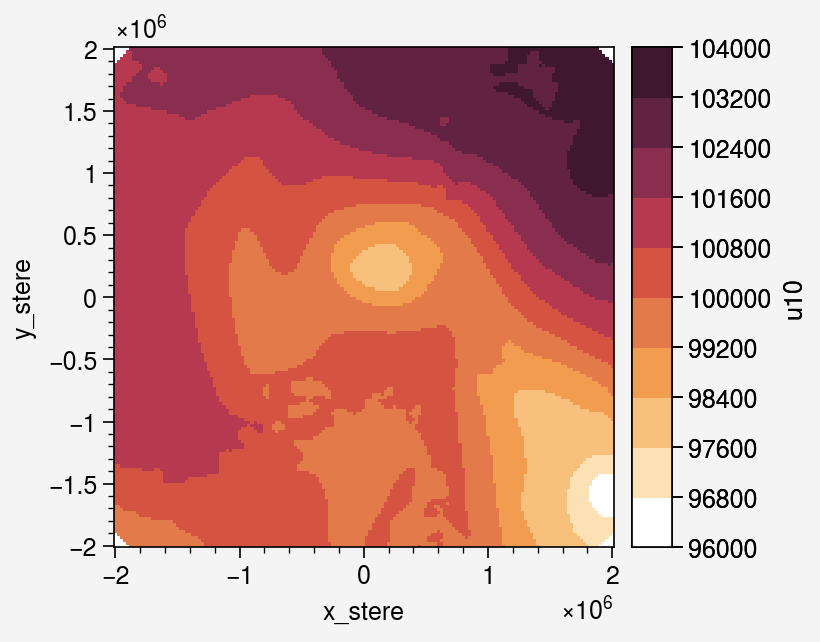

In [13]:
fig, ax = pplt.subplots()
ax.pcolormesh(ds.x_stere, ds.y_stere, ds.sel(time='2020-02-01 00:00')['u10'], colorbar='r')

In [39]:
reference_buoys = {'M1': '2019O1',
                   'M2': '2019V2',
                   'M3': '2019O3',
                   'M4': '2019O4',
                   'M5': '2019O5',
                   'M6': '2019O6',
                   'M8': '2019T69',
                   'L1': '2019T67',
                   'L2': '2019T65',
                   'L3': '2019S94',
                   'CO1': '2019T66'}

dataloc = '../data/interpolated_tracks/'
skip_buoys = []#['2019P122'] # look at this one closer
buoy_data = {}
for f in os.listdir(dataloc):
    if f[0] not in ['.']:
        dn_id, imei, sensor_id = f.split('.')[0].split('_')
        if sensor_id not in skip_buoys:
            df = pd.read_csv(dataloc + f, parse_dates=True, index_col='datetime')
            df = compute_velocity(df, method='c', rotate_uv=False)
            buoy_data[sensor_id] = df.copy()

In [3]:
ts = slice('2020-01-30 00:00', '2020-02-01 12:00')
for b in buoy_data:
    if len(buoy_data[b].loc[ts].dropna()) < 61:
        print(b, len(buoy_data[b].loc[ts].dropna()))

2019P151 51
2019P143 44
2019P146 53
2019P122 60
2019P148 53


In [4]:
buoy_data['2019O1'].head()

x_stere       y_stere  data_gap_minutes  longitude  \
datetime                                                                       
2020-01-25 00:00:00  222038.18069  204897.46553               5.0   87.70091   
2020-01-25 01:00:00  222131.00382  204910.34624              10.0   87.69077   
2020-01-25 02:00:00  222220.03134  204930.52665              10.0   87.68214   
2020-01-25 03:00:00  222307.32315  204947.78246              10.0   87.67333   
2020-01-25 04:00:00  222408.45113  204975.60468              10.0   87.66422   

                     latitude              x              y         u  \
datetime                                                                
2020-01-25 00:00:00  87.21146  222038.180691  204897.465535       NaN   
2020-01-25 01:00:00  87.21075  222131.003817  204910.346244  0.025257   
2020-01-25 02:00:00  87.21002  222220.031342  204930.526654  0.024489   
2020-01-25 03:00:00  87.20932  222307.323146  204947.782464  0.026169   
2020-01-25 04:00:00  87.20846  222408.451128  204975.604679  0.027282   

                            v     speed  
datetime                                 
2020-01-25 00:00:00       NaN       NaN  
2020-01-25 01:00:00  0.004592  0.025671  
2020-01-25 02:00:00  0.005199  0.025035  
2020-01-25 03:00:00  0.006261  0.026908  
2020-01-25 04:00:00  0.006828  0.028123

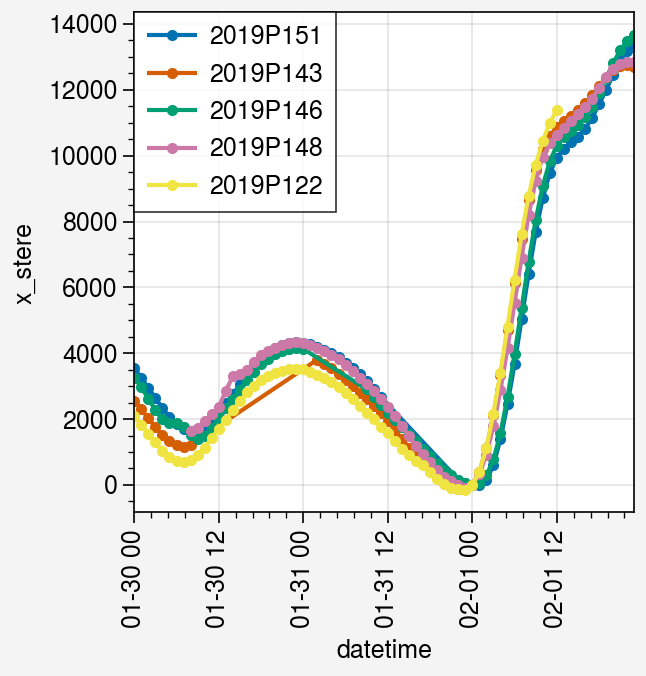

In [5]:
ts = slice('2020-01-30', '2020-02-01')
fig, ax = pplt.subplots()
for buoy in ['2019P151', '2019P143', '2019P146', '2019P148', '2019P122']:
    x0 = buoy_data[buoy].loc['2020-02-01 00:00', 'x_stere']
    ax.plot((buoy_data[buoy].x_stere - x0).loc[ts], marker='.', label=buoy)
ax.legend(ncols=1)


In [6]:
metadata = pd.read_csv('../data/adc_dn_tracks/DN_buoy_list_v2.csv')
metadata.set_index("Sensor ID", inplace=True)

In [7]:
sw_buoys = ['2019P128', '2019P184', '2019P182', '2019P127']
ne_buoys = ['2019P155', '2019P123', '2019P156', '2019P157']
l_sites = ['2019T67', '2019T65', '2019S94', '2019T66']

buoys = [b for b in buoy_data if len(buoy_data[b].loc[ts]) > 0]
buoys = [b for b in buoys if b not in sw_buoys + ne_buoys]

ts = slice('2020-01-25', '2020-02-04')
df_u = pd.DataFrame({b: buoy_data[b]['u'] for b in buoy_data})
df_v = pd.DataFrame({b: buoy_data[b]['v'] for b in buoy_data})
for buoy in buoy_data:
    buoy_data[buoy]['u_mean'] = df_u.mean(axis=1)
    buoy_data[buoy]['v_mean'] = df_v.mean(axis=1)


In [40]:
get_var = lambda var: pd.DataFrame({buoy: buoy_data[buoy][var] for buoy in buoy_data})
df_x = get_var('x_stere')/1e3
df_y = get_var('y_stere')/1e3
df_lat = get_var('latitude')
df_lon = get_var('longitude')
#df_u_mean = get_var('u_mean')
#df_v_mean = get_var('v_mean')
# df_u_along = get_var('u_along')
# df_v_along = get_var('v_along')
# df_u_across = get_var('u_across')
# df_v_across = get_var('v_across')


In [31]:
reverse_ref = {reference_buoys[b]: b for b in reference_buoys}
reverse_ref

{'2019O1': 'M1',
 '2019V2': 'M2',
 '2019O3': 'M3',
 '2019O4': 'M4',
 '2019O5': 'M5',
 '2019O6': 'M6',
 '2019T69': 'M8',
 '2019T67': 'L1',
 '2019T65': 'L2',
 '2019S94': 'L3',
 '2019T66': 'CO1'}

In [41]:
pd.DataFrame({'latitude': df_lat.loc[date],
                  'longitude': df_lon.loc[date]})

latitude  longitude
2019P142  87.25638   88.99688
2019T66   87.41451   92.94526
2019P203  87.68098   90.79029
2019P91   87.56229  100.20542
2019P151  87.40700   92.84320
...            ...        ...
2019P201  87.35627   93.65689
2019P155  86.21220   85.64320
2019O5    87.71933   97.42416
2019P158  87.40360   92.98360
2019P103  87.44828   93.28021

[69 rows x 2 columns]

In [42]:
dates = ['2020-01-31 04:00',
         '2020-02-03 06:00']
for date in dates:
    df = pd.DataFrame({'latitude': df_lat.loc[date].copy(),
                  'longitude': df_lon.loc[date].copy()})
    index = df.index.values
    new_index = []
    for idx, name in enumerate(index):
        if name in reverse_ref:
            new_index.append(reverse_ref[name])
            
        else:
            new_index.append(name)
    df.index = new_index
    df.to_csv(
    '../data/snapshot_positions_' + date + '.csv')
    del df
    del index

In [44]:
df = pd.DataFrame({'latitude': df_lat.loc[date].copy(),
                  'longitude': df_lon.loc[date].copy()})
df

latitude  longitude
2019P142  87.25638   88.99688
2019T66   87.41451   92.94526
2019P203  87.68098   90.79029
2019P91   87.56229  100.20542
2019P151  87.40700   92.84320
...            ...        ...
2019P201  87.35627   93.65689
2019P155  86.21220   85.64320
2019O5    87.71933   97.42416
2019P158  87.40360   92.98360
2019P103  87.44828   93.28021

[69 rows x 2 columns]

In [11]:
Geod = pyproj.Geod(ellps='WGS84')


In [12]:
storm_track = pd.read_csv('../data/storm_track.csv', index_col=0, parse_dates=True)

west_buoys = ['2019P128', '2019P184', '2019P182', '2019P127']
se_buoys = ['2019P155', '2019P123', '2019P112', '2019P113', '2019P114', '2019P22', '2019P119']
far_se_buoys = ['2019P156', '2019P157']
l_sites_nolm = ['2019T67', '2019T65', '2019S94']
l_colors = {'2019T67': 'tab:blue',
            '2019T65': 'tab:red',
            '2019S94': 'tab:green'}
date = '2020-02-01 00:00'
lon0, lat0 = buoy_data[reference_buoys['CO1']].loc[date, ['longitude', 'latitude']]


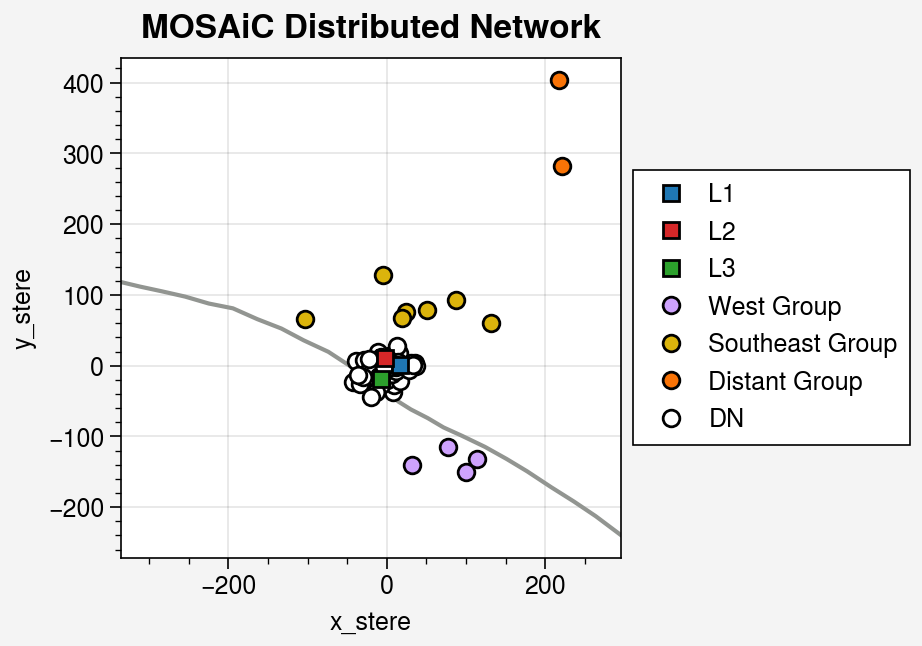

In [14]:
date = '2020-02-01 00:00'
# fig, ax = pplt.subplots(proj='ortho',
#                         proj_kw={'lon_0': 60, 'lat_0': 87}, height=4, ncols=1, share=False)
# ax.format(lonlim=(40, 125), latlim=(83,88.5), land=True,
#           latlabels=True, lonlabels=True, )
fig, ax = pplt.subplots()
x0 = df_x.loc[date, reference_buoys['CO1']]
y0 = df_y.loc[date, reference_buoys['CO1']]
ts = slice('2020-01-31 12:00', '2020-02-01 12:00')
ax.plot(storm_track.loc[ts, 'x_stere']/1e3 - x0, storm_track.loc[ts, 'y_stere']/1e3 - y0, color='gray')

# ax.quiver(storm_track.loc['2020-01-31 15:00:00', 'x_stere'],
#           storm_track.loc['2020-01-31 15:00:00', 'y_stere'] - 0.2,
#           u=10, v=0.9,  color='gray')

for site, color in zip(l_sites, ['tab:blue', 'tab:red', 'tab:green']):
    if metadata.loc[site, 'DN Station ID'] != 'LM':
        ax.plot(df_x.loc[date, site] - x0, df_y.loc[date, site] - y0, color=color, marker='s')

#ax.text(50, 85.9, 'Storm track', transform=ccrs.PlateCarree())

for b in buoy_data:
    if b not in skip_buoys:
        z = 2
        c = 'w'
        m = 'o'
        if b in west_buoys:
            c = 'lilac'
        elif b in se_buoys:
            c = 'gold'
        elif b in far_se_buoys:
            c = 'orange'
        elif b in l_sites_nolm:
            c = l_colors[b]
            z = 5
            m = 's'
        ax.plot(df_x.loc[date, b] - x0, df_y.loc[date, b] - y0, m=m, color=c, edgecolor='k', zorder=z)

h = []
l = []
for color, label in zip(
    ['tab:blue', 'tab:red', 'tab:green', 'lilac', 'gold', 'orange', 'w'],
    ['L1', 'L2', 'L3', 'West Group', 'Southeast Group', 'Distant Group', 'DN']):
    if label[0] == 'L':
        m = 's'
    else:
        m = 'o'
    h.append(ax.plot([],[], m=m, lw=0, color=color, edgecolor='k'))
    l.append(label)
ax.legend(h, l, ncols=1, loc='r', alpha=1)
ax.format(suptitle='MOSAiC Distributed Network', suptitlesize=12)
fig.format(xreverse=False, yreverse=False)
#fig.save('../figures/map_distant_buoys.jpg', dpi=300)

In [48]:
df = pd.read_csv('../data/adc_dn_tracks/P058_300234068312200_2019P156.csv', index_col='datetime', parse_dates=True)


In [49]:
begin = pd.to_datetime('2020-01-25')
end = pd.to_datetime('2020-02-04')
actual_freq = pd.to_timedelta(np.median(np.diff(df.loc[ts].index)))
expected = int((end - begin) / actual_freq)
len(df.loc[slice(begin, end)])/expected

0.8458333333333333

In [51]:
for b in far_se_buoys:
    print(b, b in buoy_data)

2019P156 True
2019P157 True


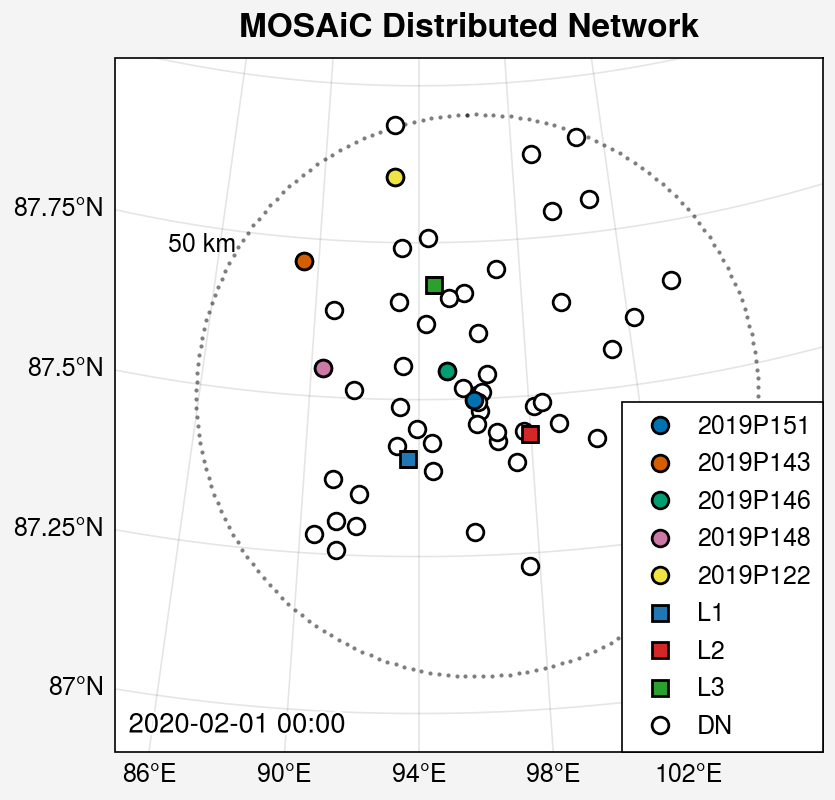

In [15]:
import warnings
warnings.simplefilter('ignore')
west_buoys = ['2019P128', '2019P184', '2019P182', '2019P127']
se_buoys = ['2019P155', '2019P123', '2019P112', '2019P113', '2019P114', '2019P22', '2019P119']
far_se_buoys = ['2019P156', '2019P157']
l_sites_nolm = ['2019T67', '2019T65', '2019S94']
l_colors = {'2019T67': 'tab:blue',
            '2019T65': 'tab:red',
            '2019S94': 'tab:green'}
date = '2020-02-01 00:00'
lon0, lat0 = buoy_data[reference_buoys['CO1']].loc[date, ['longitude', 'latitude']]


fig, ax = pplt.subplots(proj='ortho', proj_kw={'lon_0': 94, 'lat_0': 87}, height=4, ncols=1, share=False)
ax.format(lonlim=(85, 106), latlim=(86.9,88), land=True, latlabels=True, lonlabels=True,
         lonlocator=np.arange(86, 104, 4), latlocator=(87, 87.25, 87.5, 87.75, 88))
n = 200
theta=np.linspace(0, 360, n)
lon_circ, lat_circ, az = Geod.fwd(lon0 * np.ones(n), lat0 * np.ones(n), theta, 50e3 * np.ones(n))
ax.plot(lon_circ, lat_circ, lw=0, color='k', m='.', ms=1, alpha=0.5)

for b in buoy_data:
    if b not in []:
        z = 2
        c = 'w'
        m = 'o'
        if b in west_buoys:
            c = 'lilac'
        elif b in se_buoys:
            c = 'gold'
        elif b in far_se_buoys:
            c = 'orange'
        elif b in l_sites_nolm:
            c = l_colors[b]
            z = 5
            m = 's'
        if b == '2019P122':
            c = 'pink'
        ax.plot(df_lon.loc[date, b], df_lat.loc[date, b], m=m, color=c, edgecolor='k', zorder=z)
ax.text(84, 87.7, '50 km', transform=ccrs.PlateCarree())
h = []
l = []
for buoy in ['2019P151', '2019P143', '2019P146', '2019P148', '2019P122']:
    h.append(ax.plot(df_lon.loc[date, buoy],df_lat.loc[date, buoy], m=m, lw=0, edgecolor='k'))
    l.append(buoy)
for color, label in zip(
    ['tab:blue', 'tab:red', 'tab:green', 'w'],
    ['L1', 'L2', 'L3',  'DN']):
    if label[0] == 'L':
        m = 's'
    else:
        m = 'o'
    h.append(ax.plot([],[], m=m, lw=0, color=color, edgecolor='k'))
    l.append(label)
ax.legend(h, l, ncols=1, loc='lr', alpha=1)
ax.format(lltitle=date, suptitle='MOSAiC Distributed Network', suptitlesize=12)
#fig.save('../figures/map_dn_buoys.jpg', dpi=300)

In [1]:

fig, ax = pplt.subplots(proj='ortho',
                        proj_kw={'lon_0': 60, 'lat_0': 87}, height=4, ncols=1, share=False)
ax.format(lonlim=(40, 125), latlim=(83,88.5), land=True,
          latlabels=True, lonlabels=True, )
ax.plot(storm_track['lon_smoothed'], storm_track['lat_smoothed'], color='gray')

ax.quiver(storm_track.loc['2020-01-31 15:00:00', 'lon_smoothed'],
          storm_track.loc['2020-01-31 15:00:00', 'lat_smoothed'] - 0.2,
          u=10, v=0.9,  color='gray')

for site, color in zip(l_sites, ['tab:blue', 'tab:red', 'yellowgreen']):
    if metadata.loc[site, 'DN Station ID'] != 'LM':
        ax.plot(df_lon.loc[date, site], df_lat.loc[date, site], color=color, marker='s')
n = 50
theta=np.linspace(0, 360, n)
lon_circ, lat_circ, az = Geod.fwd(lon0 * np.ones(n), lat0 * np.ones(n), theta, 50e3 * np.ones(n))
ax.plot(lon_circ, lat_circ, lw=0, color='k', m='.', ms=1, alpha=0.5)

n = 200
theta=np.linspace(0, 360, n)
lon_circ, lat_circ, az = Geod.fwd(lon0 * np.ones(n), lat0 * np.ones(n), theta, 200e3 * np.ones(n))
ax.plot(lon_circ, lat_circ, lw=0, color='k', m='.', ms=1, alpha=0.5)

n = 400
theta = np.linspace(0, 360, n)
lon_circ, lat_circ, az = Geod.fwd(lon0 * np.ones(n), lat0 * np.ones(n), theta, 400e3 * np.ones(n))
ax.plot(lon_circ, lat_circ, lw=0, color='k', m='.', ms=1, alpha=0.5)


ax.text(108, 87.25, '50 km', transform=ccrs.PlateCarree())
ax.text(120, 86, '100 km', transform=ccrs.PlateCarree())
ax.text(132, 84.5, '400 km', transform=ccrs.PlateCarree())

ax.text(50, 85.9, 'Storm track', transform=ccrs.PlateCarree())

for b in buoy_data:
    if b not in skip_buoys:
        z = 2
        c = 'w'
        m = 'o'
        if b in west_buoys:
            c = 'lilac'
        elif b in se_buoys:
            c = 'gold'
        elif b in far_se_buoys:
            c = 'orange'
        elif b in l_sites_nolm:
            c = l_colors[b]
            z = 5
            m = 's'
        ax.plot(df_lon.loc[date, b], df_lat.loc[date, b], m=m, color=c, edgecolor='k', zorder=z)

h = []
l = []
for color, label in zip(
    ['tab:blue', 'tab:red', 'tab:green', 'lilac', 'gold', 'orange', 'w'],
    ['L1', 'L2', 'L3', 'West Group', 'Southeast Group', 'Distant Group', 'DN']):
    if label[0] == 'L':
        m = 's'
    else:
        m = 'o'
    h.append(ax.plot([],[], m=m, lw=0, color=color, edgecolor='k'))
    l.append(label)
ax.legend(h, l, ncols=1, loc='ur', alpha=1)
ax.format(lltitle=date, suptitle='MOSAiC Distributed Network', suptitlesize=12)
fig.save('../figures/map_distant_buoys.jpg', dpi=300)

NameError: name 'pplt' is not defined

In [69]:
date = '2020-02-01 00:00'
x0, y0 = buoy_data[reference_buoys['CO1']].loc[date, ['x', 'y']]


In [117]:
buoy_data[buoy]

x_stere       y_stere  data_gap_minutes  longitude  \
datetime                                                                       
2020-01-25 00:00:00  173169.48845  170253.40537              30.0    89.5135   
2020-01-25 01:00:00  173244.08932  170285.72482              60.0    89.5066   
2020-01-25 02:00:00  173315.72787  170321.05374              60.0    89.5007   
2020-01-25 03:00:00  173366.56406  170346.62657              60.0    89.4966   
2020-01-25 04:00:00  173413.23992  170391.89450              60.0    89.4965   
...                           ...           ...               ...        ...   
2020-02-01 08:00:00  164458.49682  175457.92713              60.0    91.8534   
2020-02-01 09:00:00  165400.00450  175956.40705              60.0    91.7713   
2020-02-01 10:00:00  166126.60350  176478.01026              60.0    91.7306   
2020-02-01 11:00:00  166680.85749  177012.93749              60.0    91.7219   
2020-02-01 12:00:00  167069.58087  177554.86078              30.0    91.7427   

                     latitude              x              y         u  \
datetime                                                                
2020-01-25 00:00:00   87.7585  173169.488449  170253.405369       NaN   
2020-01-25 01:00:00   87.7578  173244.089324  170285.724822  0.020311   
2020-01-25 02:00:00   87.7571  173315.727869  170321.053743  0.017010   
2020-01-25 03:00:00   87.7566  173366.564062  170346.626574  0.013543   
2020-01-25 04:00:00   87.7560  173413.239921  170391.894496  0.011685   
...                       ...            ...            ...       ...   
2020-02-01 08:00:00   87.7803  164458.496817  175457.927134  0.293431   
2020-02-01 09:00:00   87.7710  165400.004499  175956.407046  0.231681   
2020-02-01 10:00:00   87.7629  166126.603500  176478.010256  0.177896   
2020-02-01 11:00:00   87.7558  166680.857491  177012.937492  0.130969   
2020-02-01 12:00:00   87.7497  167069.580875  177554.860784       NaN   

                            v     speed  
datetime                                 
2020-01-25 00:00:00       NaN       NaN  
2020-01-25 01:00:00  0.009396  0.022379  
2020-01-25 02:00:00  0.008459  0.018997  
2020-01-25 03:00:00  0.009839  0.016740  
2020-01-25 04:00:00  0.011730  0.016557  
...                       ...       ...  
2020-02-01 08:00:00  0.145834  0.327673  
2020-02-01 09:00:00  0.141678  0.271568  
2020-02-01 10:00:00  0.146740  0.230607  
2020-02-01 11:00:00  0.149563  0.198801  
2020-02-01 12:00:00       NaN       NaN  

[181 rows x 10 columns]

In [152]:
lats = np.hstack([np.arange(85, 90, 0.5), np.arange(89.5, 84, -0.5)])
lats

array([85. , 85.5, 86. , 86.5, 87. , 87.5, 88. , 88.5, 89. , 89.5, 89.5,
       89. , 88.5, 88. , 87.5, 87. , 86.5, 86. , 85.5, 85. , 84.5])

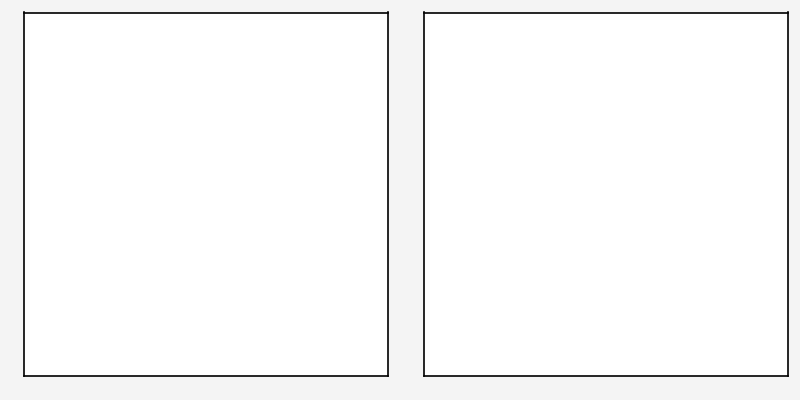

In [153]:
from scipy.interpolate import interp1d
crs0 = pyproj.CRS('WGS84')
crs1 = pyproj.CRS('epsg:3413')
transformer_ll = pyproj.Transformer.from_crs(crs0, crs_to=crs1, always_xy=True)
transformer_xy = pyproj.Transformer.from_crs(crs1, crs_to=crs0, always_xy=True)

lats = np.hstack([np.arange(85, 90, 0.5), np.arange(89.5, 84, -0.5)])
lons = np.arange(-180, 180, 5)
lons, lats = np.meshgrid(lons, lats)
xylon, xylat = transformer_ll.transform(lons, lats)

lat_labels = []
lat_y = []
lon_labels = []
lon_x = []
#for idx in range(0, xylon.shape[0]):
    #if np.any(xylon[idx,:] < x0) & np.any(xylon[idx,:] > x0):
#    y = interp1d(xylon[idx,:], xylat[idx,:])(x0)
#         lat_y.append(y)
#         lat_labels.append(lats[idx,0])
#for idx in range(0, xylon.shape[1]):
#    if np.any(xylat[:,idx] < y0) & np.any(xylat[:,idx] > y0):
 #       if np.any(xylon[:,idx] < x0) & np.any(xylon[:,idx] > x0):            
#    x = interp1d(xylat[:,idx], xylon[:,idx])(y0)
#             lon_x.append(x)
#             lon_labels.append(lons[0,idx])
            
# lat_y = list(np.array(lat_y))
# lat_labels = [str(x) + '$^\circ$' for x in lat_labels]
# lon_labels = [str(x) + '$^\circ$' for x in lon_labels]
# lon_x = list(np.array(lon_x))

#df_lon = pd.DataFrame({buoy: buoy_data[buoy]['longitude'] for buoy in buoy_data})
#df_lat = pd.DataFrame({buoy: buoy_data[buoy]['latitude'] for buoy in buoy_data})

pplt.rc['reso'] = 'med' 

fig, axs = pplt.subplots(width=4, ncols=2, share=False)
axs.format(grid=False)
for ax in axs:
    for idx in range(xylon.shape[1]):
        ax.plot(xylon[:,idx], xylat[:,idx], color='light gray', lw=0.5)
    for idx in range(xylon.shape[0]):
        ax.plot(xylon[idx,:], xylat[idx,:], color='light gray', lw=0.5)

    ax.plot(xylon[0,:], xylat[0,:], color='r', lw=0.5)



    ax.format(xlim=(x0-500, x0+500),
             ylim=(y0-500, y0+500))

#    ax.plot([x0+0.5e5, x0+1.5e5], [y0+5e4, y0+5e4], color='k', lw=2)
#    ax.text(x0+0.4e5, y0+0.6e5, '100 km')

    ax.format(xtickminor=False,
              ytickminor=False,
             ylocator=lat_y,
             yformatter=lat_labels,
              xlocator=lon_x[2:],
              xformatter=lon_labels[2:],
              ylabel='', xlabel='')

In [314]:
date = '2020-02-01 00:00'
for b in far_se_buoys:
    d = np.sqrt((df_x.loc[date, b] - x0)**2 +  (df_y.loc[date, b]-y0)**2)
    print(b, np.round(d/1e3), 1)

2019P156 358.0 1
2019P157 458.0 1


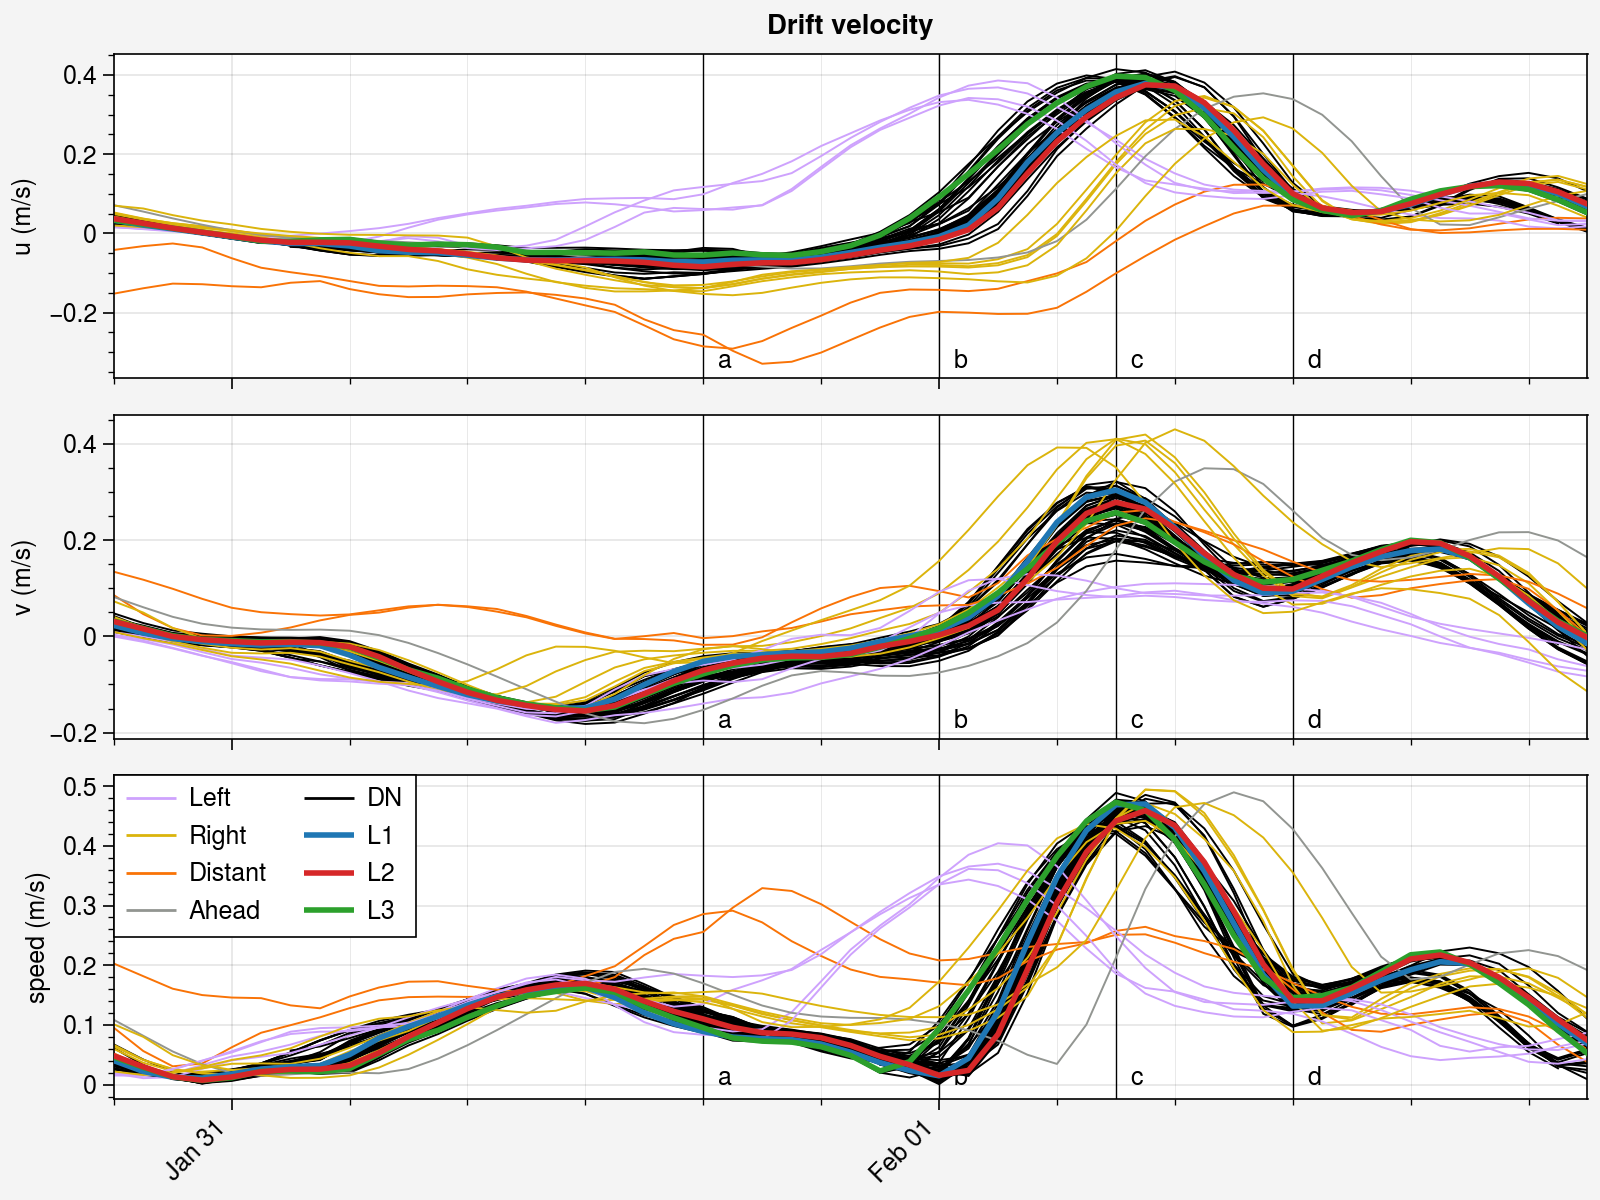

In [56]:
skip_buoys = []
l_colors = {'2019T67': 'tab:blue',
            '2019T65': 'tab:red',
            '2019S94': 'tab:green'}


ts = slice('2020-01-30 20:00', '2020-02-02 02:00')
fig, axs = pplt.subplots(width=8, height=6, nrows=3, sharey=False)
for var, ax in zip(['u', 'v', 'speed'], axs):
    for b in buoy_data:
        if b not in skip_buoys:
            z = 2
            lw = 0.7
            if b in west_buoys:
                c = 'lilac'
            elif b in se_buoys:
                c = 'gold'
            elif b in far_se_buoys:
                c = 'orange'

            elif b in l_colors:
                c = l_colors[b]
                lw = 2
                z = 5
            else:
                c = 'k'
                z = 0
                

            if b == '2019P22':
                c = 'gray'
            ax.plot(buoy_data[b].loc[ts, var].resample('1H').asfreq(),
                    c=c, zorder=z, marker='', lw=lw)

    ax.format(ylabel=var + ' (m/s)', xlabel='', xrotation=45, xformatter='%b %d',
             xlocator='day',
              xminorlocator=1/6, xgridminor=True, suptitle='Drift velocity')
    
zoom_plot_dates = ['2020-01-31 16:00', '2020-02-01 0:00', '2020-02-01 06:00', '2020-02-01 12:00']
zoom_plot_dates = [pd.to_datetime(x) for x in zoom_plot_dates]


for abc, date in zip(['a', 'b', 'c', 'd'], zoom_plot_dates):
    for ax in axs:
        ax.axvline(date, color='k', lw=0.5, zorder=0)
    axs[0].text(date + pd.to_timedelta('30min'), -0.34, abc, color='k', zorder=4)
    axs[1].text(date + pd.to_timedelta('30min'), -0.19, abc, color='k', zorder=4)
    axs[2].text(date + pd.to_timedelta('30min'), 0, abc, color='k', zorder=4)

h = []
l = []
for color, label in zip(
    ['lilac',  'gold', 'orange', 'gray', 'k', 'tab:blue', 'tab:red', 'tab:green'],
    ['Left', 'Right', 'Distant', 'Ahead', 'DN',  'L1', 'L2', 'L3']):
    if label in ['L1', 'L2', 'L3']:
        lw = 2
    else:
        lw = 1

    h.append(ax.plot([],[], lw=lw, color=color, ))
    l.append(label)
ax.legend(h, l, ncols=2, loc='ul', alpha=1, order='F')
fig.save('../figures/velocity_timeseries_ice_stereographic_uv.jpg', dpi=300)


The figure above shows the velocity components and the velocity magnitude  for this case study. I've colored a few subsets based on distance from the CO. 

In [502]:
l_sites

['2019T67', '2019T65', '2019S94', '2019T66']

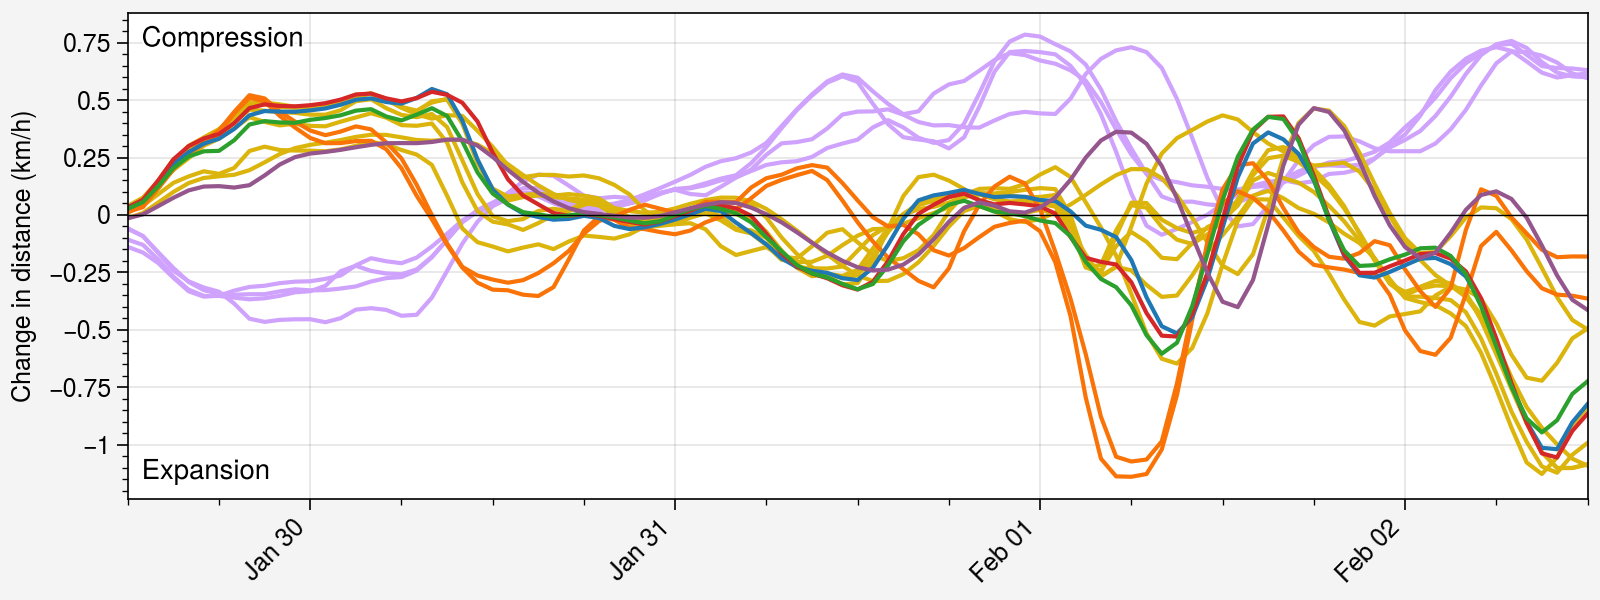

In [506]:
# TBD
# Stretching and shrinking along the storm track.
# Where would we see opening and when?
fig, ax = pplt.subplots(width=8, height=3)
b2 = '2019T66'
for b1 in west_buoys:
    d = np.sqrt((df_x.loc[ts, b1] - df_x.loc[ts, b2])**2 +  (df_y.loc[ts, b1]-df_x.loc[ts, b2])**2) / 1e3
    ax.plot(d.index, np.gradient(d), label='DN to West Buoy', c='lilac')
    
for b1 in se_buoys:
    d = np.sqrt((df_x.loc[ts, b1] - df_x.loc[ts, b2])**2 +  (df_y.loc[ts, b1]-df_x.loc[ts, b2])**2) / 1e3
    ax.plot(d.index, np.gradient(d), label='DN to SE Buoy', c='gold')

for b1 in far_se_buoys:
    d = np.sqrt((df_x.loc[ts, b1] - df_x.loc[ts, b2])**2 +  (df_y.loc[ts, b1]-df_x.loc[ts, b2])**2) / 1e3
    ax.plot(d.index, np.gradient(d), label='DN to Distant Buoy', c='orange')

for b1 in l_sites_nolm:
    d = np.sqrt((df_x.loc[ts, b1] - df_x.loc[ts, b2])**2 +  (df_y.loc[ts, b1]-df_x.loc[ts, b2])**2) / 1e3
    ax.plot(d.index, np.gradient(d), label='CO to L Sites', c=l_colors[b1])

    

b1 = '2019P22'
b2 = '2019T67'
d = np.sqrt((df_x.loc[ts, b1] - df_x.loc[ts, b2])**2 +  (df_y.loc[ts, b1]-df_x.loc[ts, b2])**2) / 1e3
ax.plot(d.index, np.gradient(d), label='DN to North Buoy', c='purple')
    
    
ax.axhline(0, color='k', lw=0.5)
ax.format(ylabel='Change in distance (km/h)', xlabel='', xrotation=45, xformatter='%b %d',
             xlocator='day', xminorlocator=1/4, ultitle='Compression', lltitle='Expansion')
fig.save('../figures/stretching_buoys.jpg', dpi=300)

Deformation (large scale)

Polygons: 
- Purple buoys
- Outer edge of DN


In [38]:
pd.DataFrame({'latitude': df_lat.loc['2020-02-01 00:00',:],
              'longitude': df_lon.loc['2020-02-01 00:00',:]}).to_csv('../data/positions_feb1.csv')

In [140]:
polygons = {'Left 1': ['2019P184', '2019P127', '2019P182', '2019P128'],
            'Left 2': ['2019P184', '2019P124', '2019O6', '2019P127'],
            'Left 3': ['2019O6', '2019P127','2019O1'],
            'DN_set_1': ['2019P124', '2019P125', '2019P102', '2019P198'],
            'DN_set_2': ['2019P125', '2019P91', '2019P193', '2019P196'],
            'DN_set_3': ['2019P136', '2019P187', '2019P92', '2019P103'],
            'DN_set_4': ['2019P191', '2019P148', '2019P139', '2019P195'],
            'DN_set_5': ['2019P143', '2019P203', '2019T69', '2019P105'],
            'Full DN': ['2019P125', '2019P91', '2019P187', '2019P191', '2019P143'],
            'North group': ['2019P22', '2019P91', '2019P187'],
            'Right group 1': ['2019P123', '2019P112', '2019P187'],
            'Right group 2': ['2019P114', '2019P113', '2019P155'],
            'Right group 3': ['2019P113', '2019P92', '2019P137', '2019P119'],
            'Distant group': ['2019P123', '2019P157', '2019P156', '2019P155'],
            'Very large group': ['2019P22', '2019P123', '2019P157', '2019P156',
                                 '2019P155', '2019P182', '2019P128', '2019P184',
                                 '2019P124']}


In [141]:
buoy_set

['2019P123', '2019P157', '2019P156', '2019P155']

In [142]:
colors = {'Left 1': 'lilac',
          'Left 2': 'purple',
          'Left 3': 'maroon',
          'DN_set_1': 'k',
          'DN_set_2': 'k',
          'DN_set_3': 'k',
          'DN_set_4': 'k',
          'DN_set_5': 'k',
          'Full DN': 'blue',
          'North group': 'green',
          'Right group 1': 'goldenrod',
          'Right group 2': 'gold',
          'Right group 3': 'yellow',
          'Distant group': 'orange',
          'Very large group': 'forest green'}

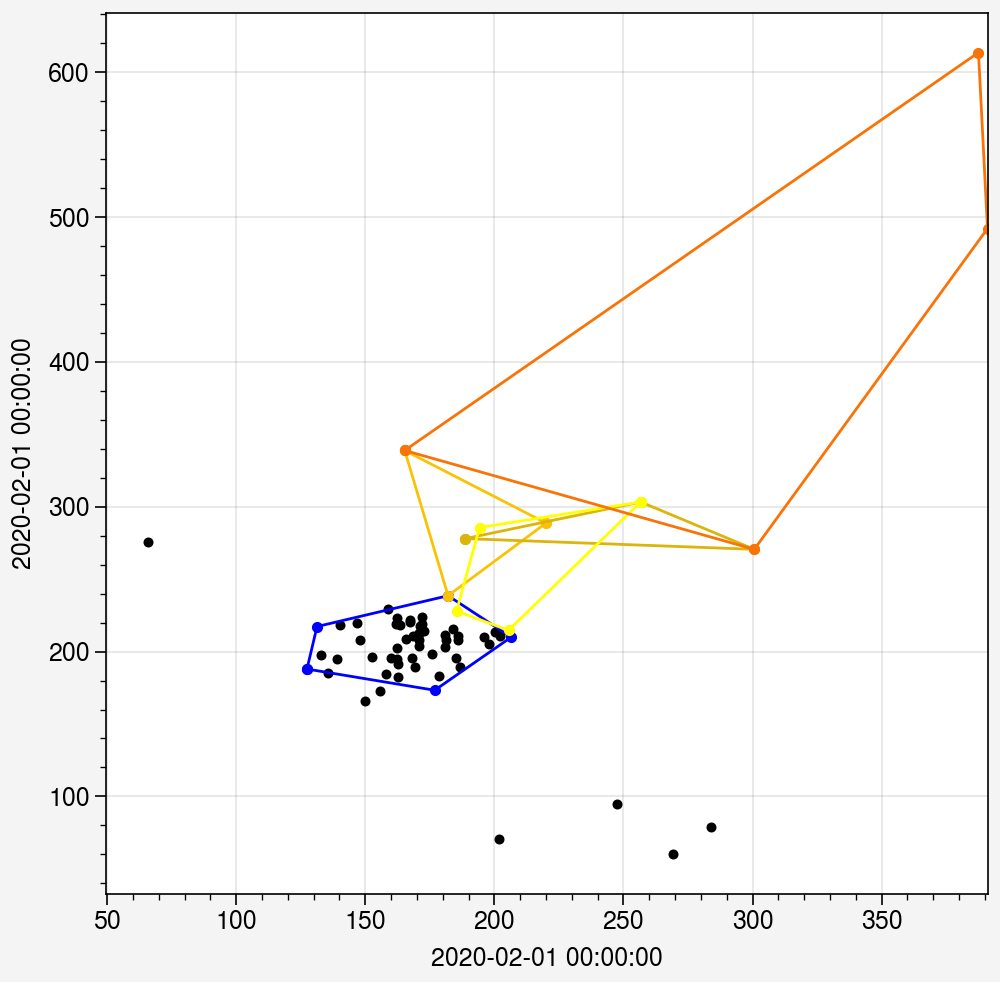

In [144]:
fig, ax = pplt.subplots(width=5)
date = '2020-02-01 00:00'
ax.scatter(df_x.loc[date, :],
           df_y.loc[date, :], marker='.', color='k', zorder=1)

for set_name in ['Full DN', 'Right group 1', 'Right group 2', 'Right group 3', 'Distant group']:
    buoy_set = polygons[set_name]
    ax.plot(df_x.loc[date, buoy_set + [buoy_set[0]]],
            df_y.loc[date, buoy_set + [buoy_set[0]]],
                label='', marker='.', lw=1, zorder=2, color=colors[set_name])
ax.format(xreverse=False)
fig.save('../figures/polygon_reference_right.jpg', dpi=300)

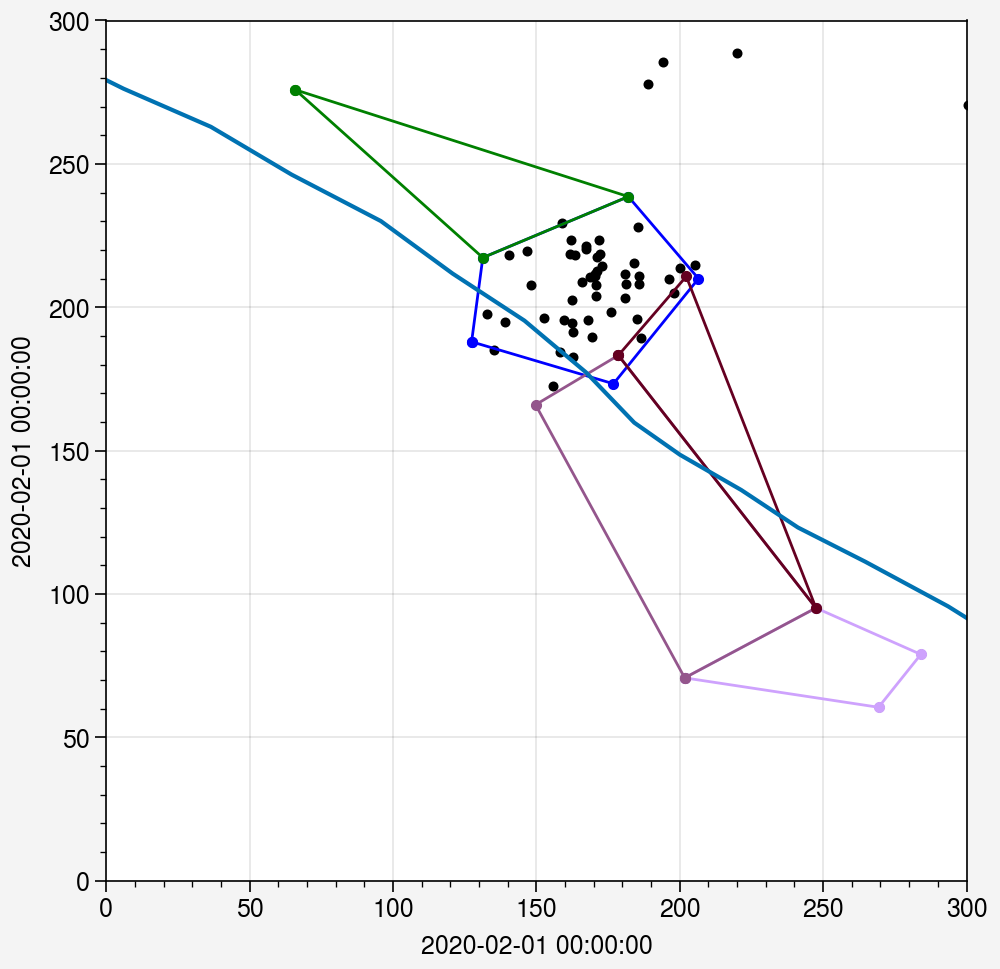

In [157]:
fig, ax = pplt.subplots(width=5)
date = '2020-02-01 00:00'
ax.scatter(df_x.loc[date, :],
           df_y.loc[date, :], marker='.', color='k', zorder=1)

for set_name in ['Full DN', 'Left 1', 'Left 2', 'Left 3', 'North group']:
    buoy_set = polygons[set_name]
    ax.plot(df_x.loc[date, buoy_set + [buoy_set[0]]],
            df_y.loc[date, buoy_set + [buoy_set[0]]],
                label='', marker='.', lw=1, zorder=2, color=colors[set_name])

ax.plot(storm_track.loc[:, 'x_stere']/1e3, storm_track.loc[:, 'y_stere']/1e3)
ax.format(xreverse=False, xlim=(0, 300), ylim=(0, 300))
fig.save('../figures/polygon_reference_left.jpg', dpi=300)

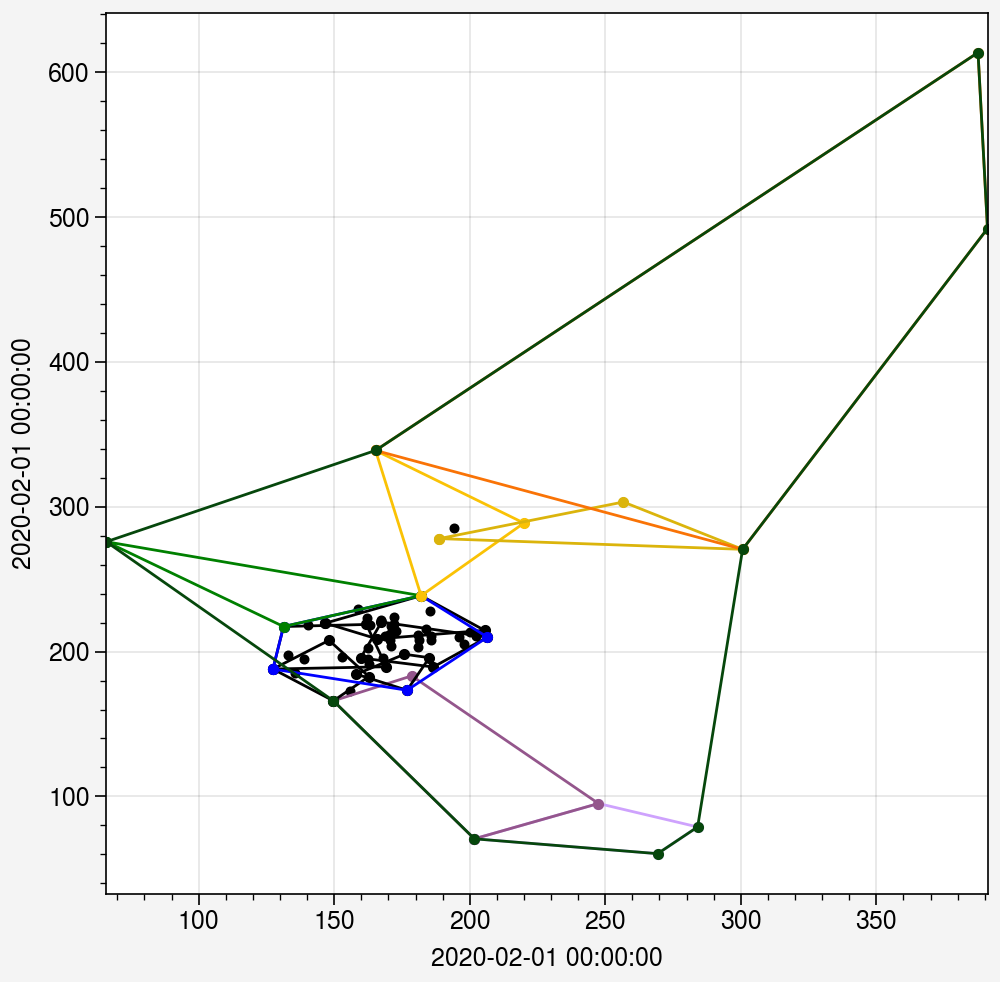

In [123]:
fig, ax = pplt.subplots(width=5)
date = '2020-02-01 00:00'
ax.scatter(df_x.loc[date, :],
           df_y.loc[date, :], marker='.', color='k', zorder=1)

for set_name in polygons:
    buoy_set = polygons[set_name]
    ax.plot(df_x.loc[date, buoy_set + [buoy_set[0]]],
            df_y.loc[date, buoy_set + [buoy_set[0]]],
                label='', marker='.', lw=1, zorder=2, color=colors[set_name])
ax.format(xreverse=False)
fig.save('../figures/polygon_reference.jpg', dpi=300)

In [80]:
for buoy in polygons['Left between']:
    print(buoy, len(buoy_data[buoy].dropna()))

2019P184 261
2019P124 263
2019O6 261
2019P127 263


In [146]:
strain_rates = {}
for set_name in polygons:
    strain_rates[set_name] = drifter.compute_strain_rate_components(polygons[set_name][::-1], buoy_data)

In [147]:
strain_rates[set_name].columns

Index(['divergence', 'vorticity', 'pure_shear', 'normal_shear',
       'maximum_shear_strain_rate', 'area', 'shape_flag'],
      dtype='object')

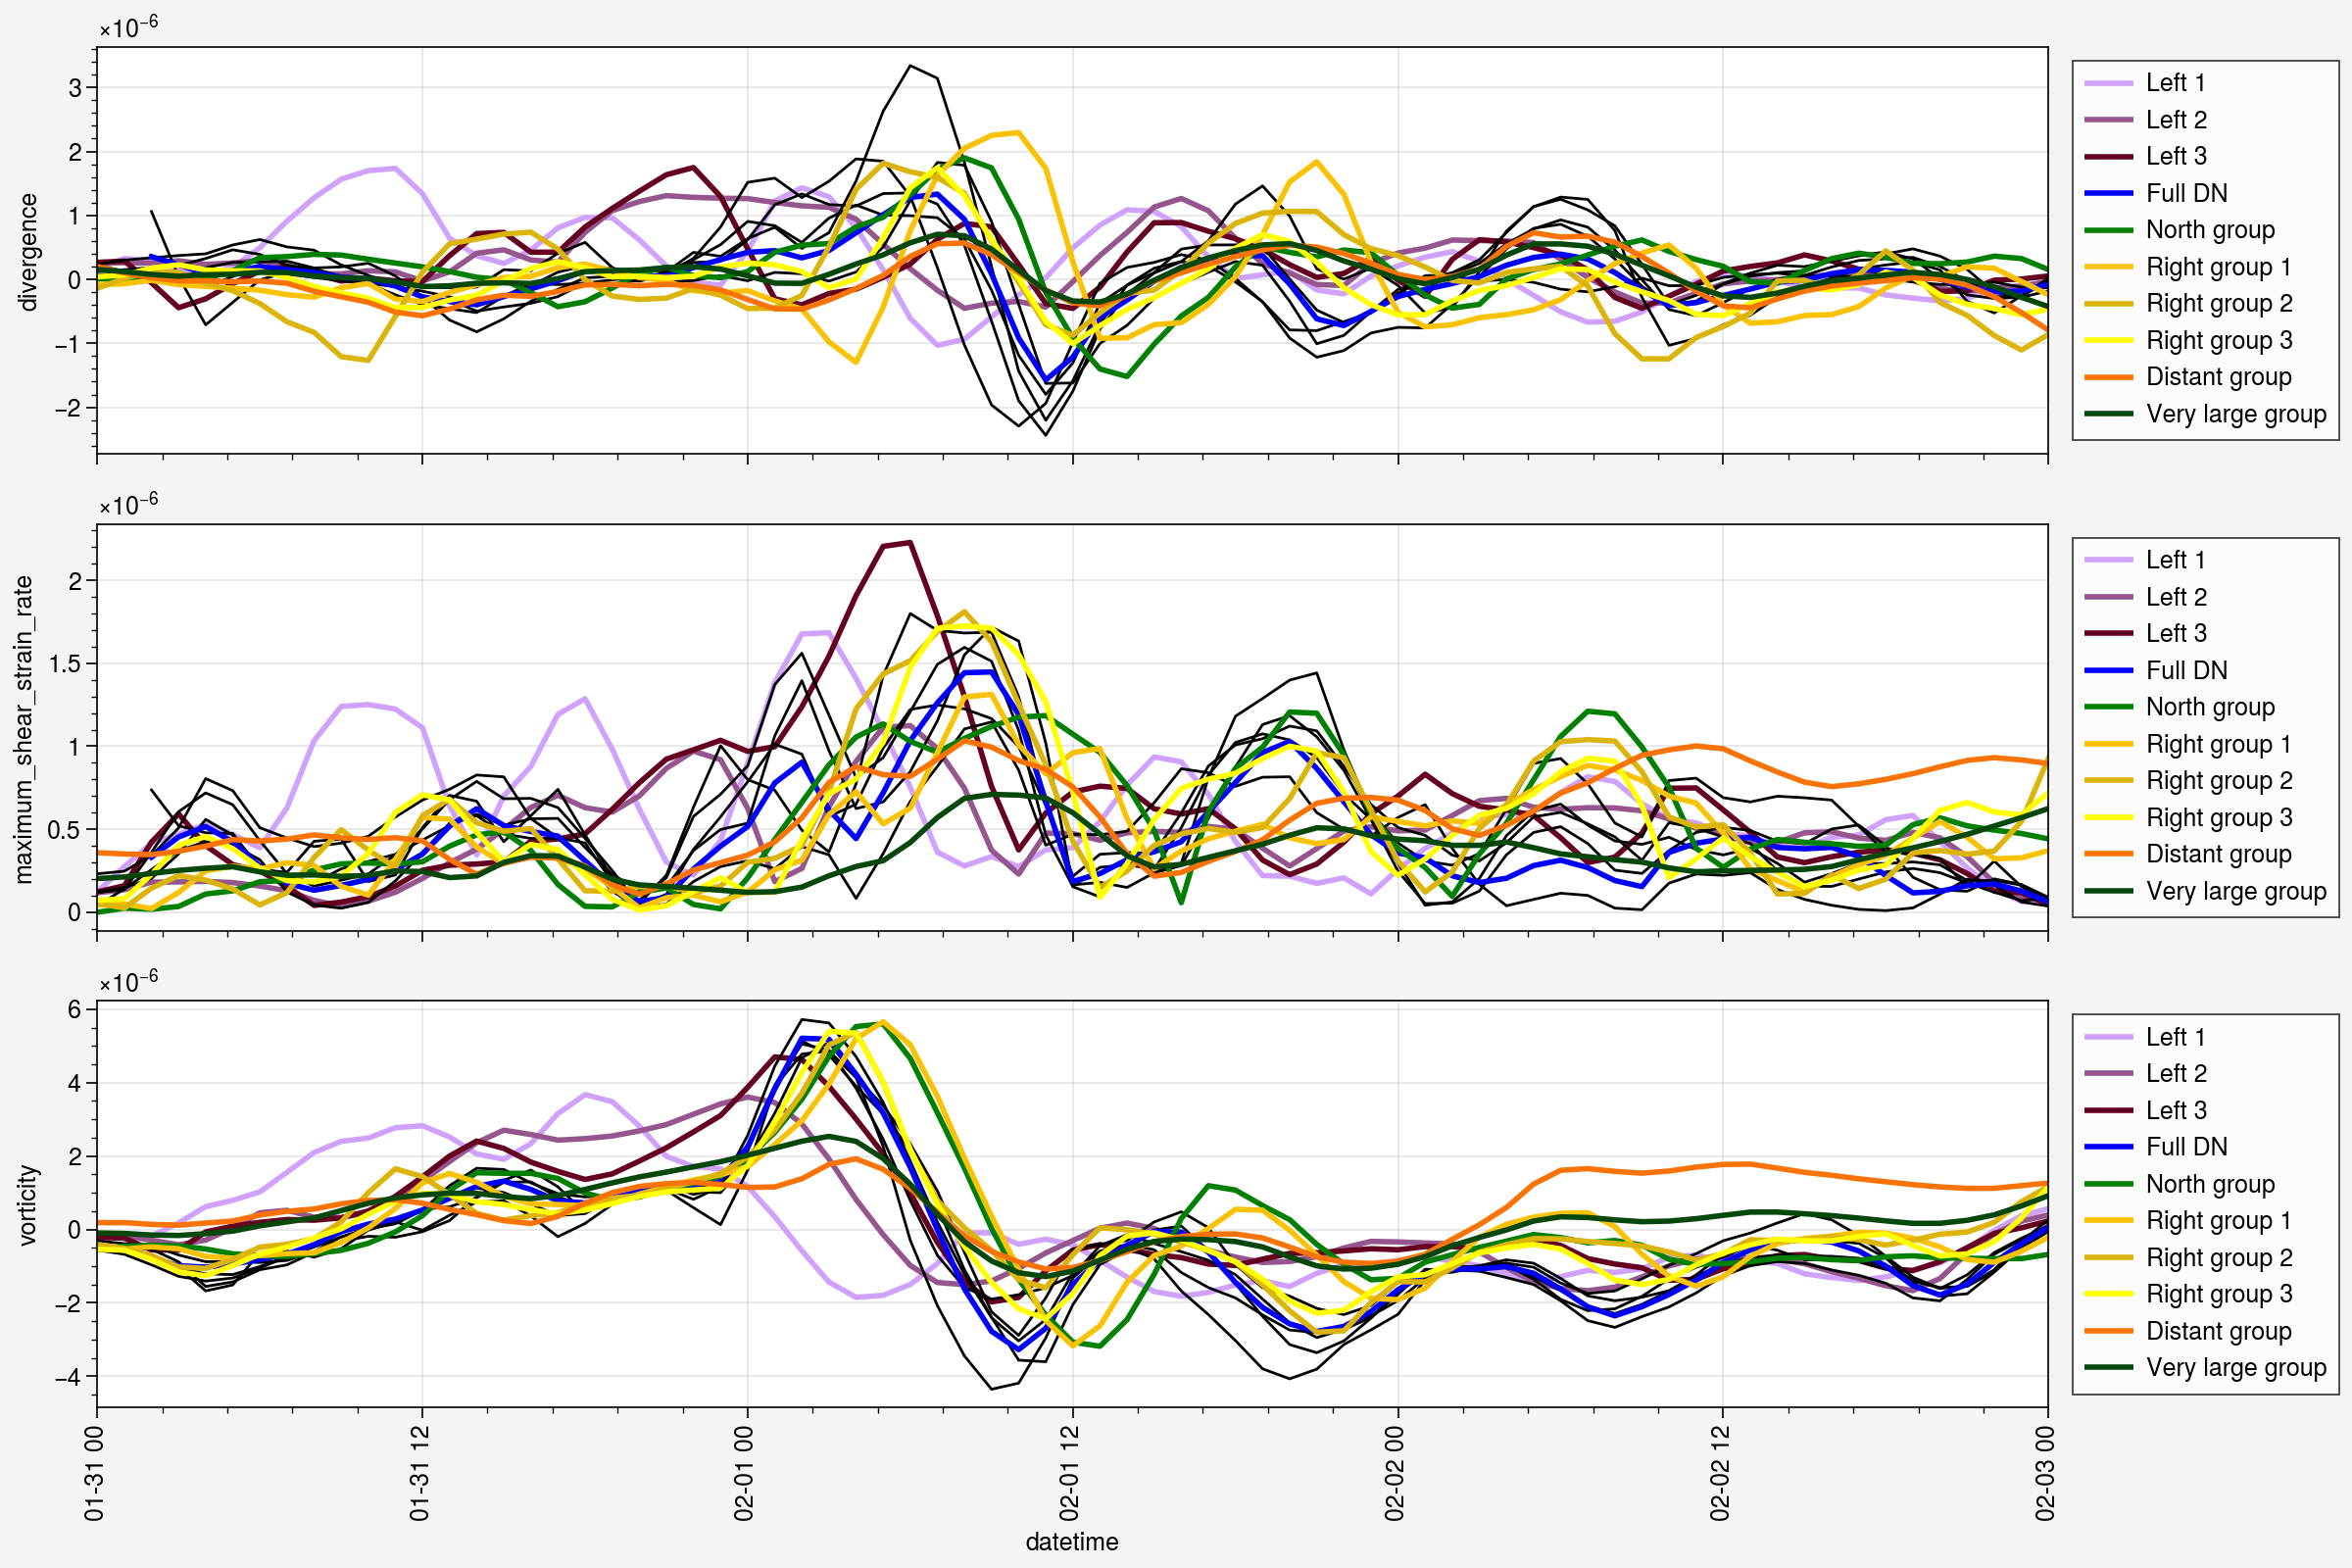

In [148]:
ts = slice('2020-01-31 00:00', '2020-02-03 00:00')
fig, ax = pplt.subplots(width=12, height=8, nrows=3, sharey=False)
for set_name in strain_rates:
    if set_name[0:2] == 'DN':
        lw = 1
        label = ''
    else:
        lw = 2
        label = set_name
    ax[0].plot(strain_rates[set_name].divergence.loc[ts], color=colors[set_name], lw=lw, label=label)
    ax[1].plot(strain_rates[set_name].maximum_shear_strain_rate.loc[ts], color=colors[set_name], lw=lw, label=label)    
    ax[2].plot(strain_rates[set_name].vorticity.loc[ts], color=colors[set_name], lw=lw, label=label)        
ax.legend(loc='r', ncols=1)
fig.save('../figures/strain_rates.png', dpi=300)

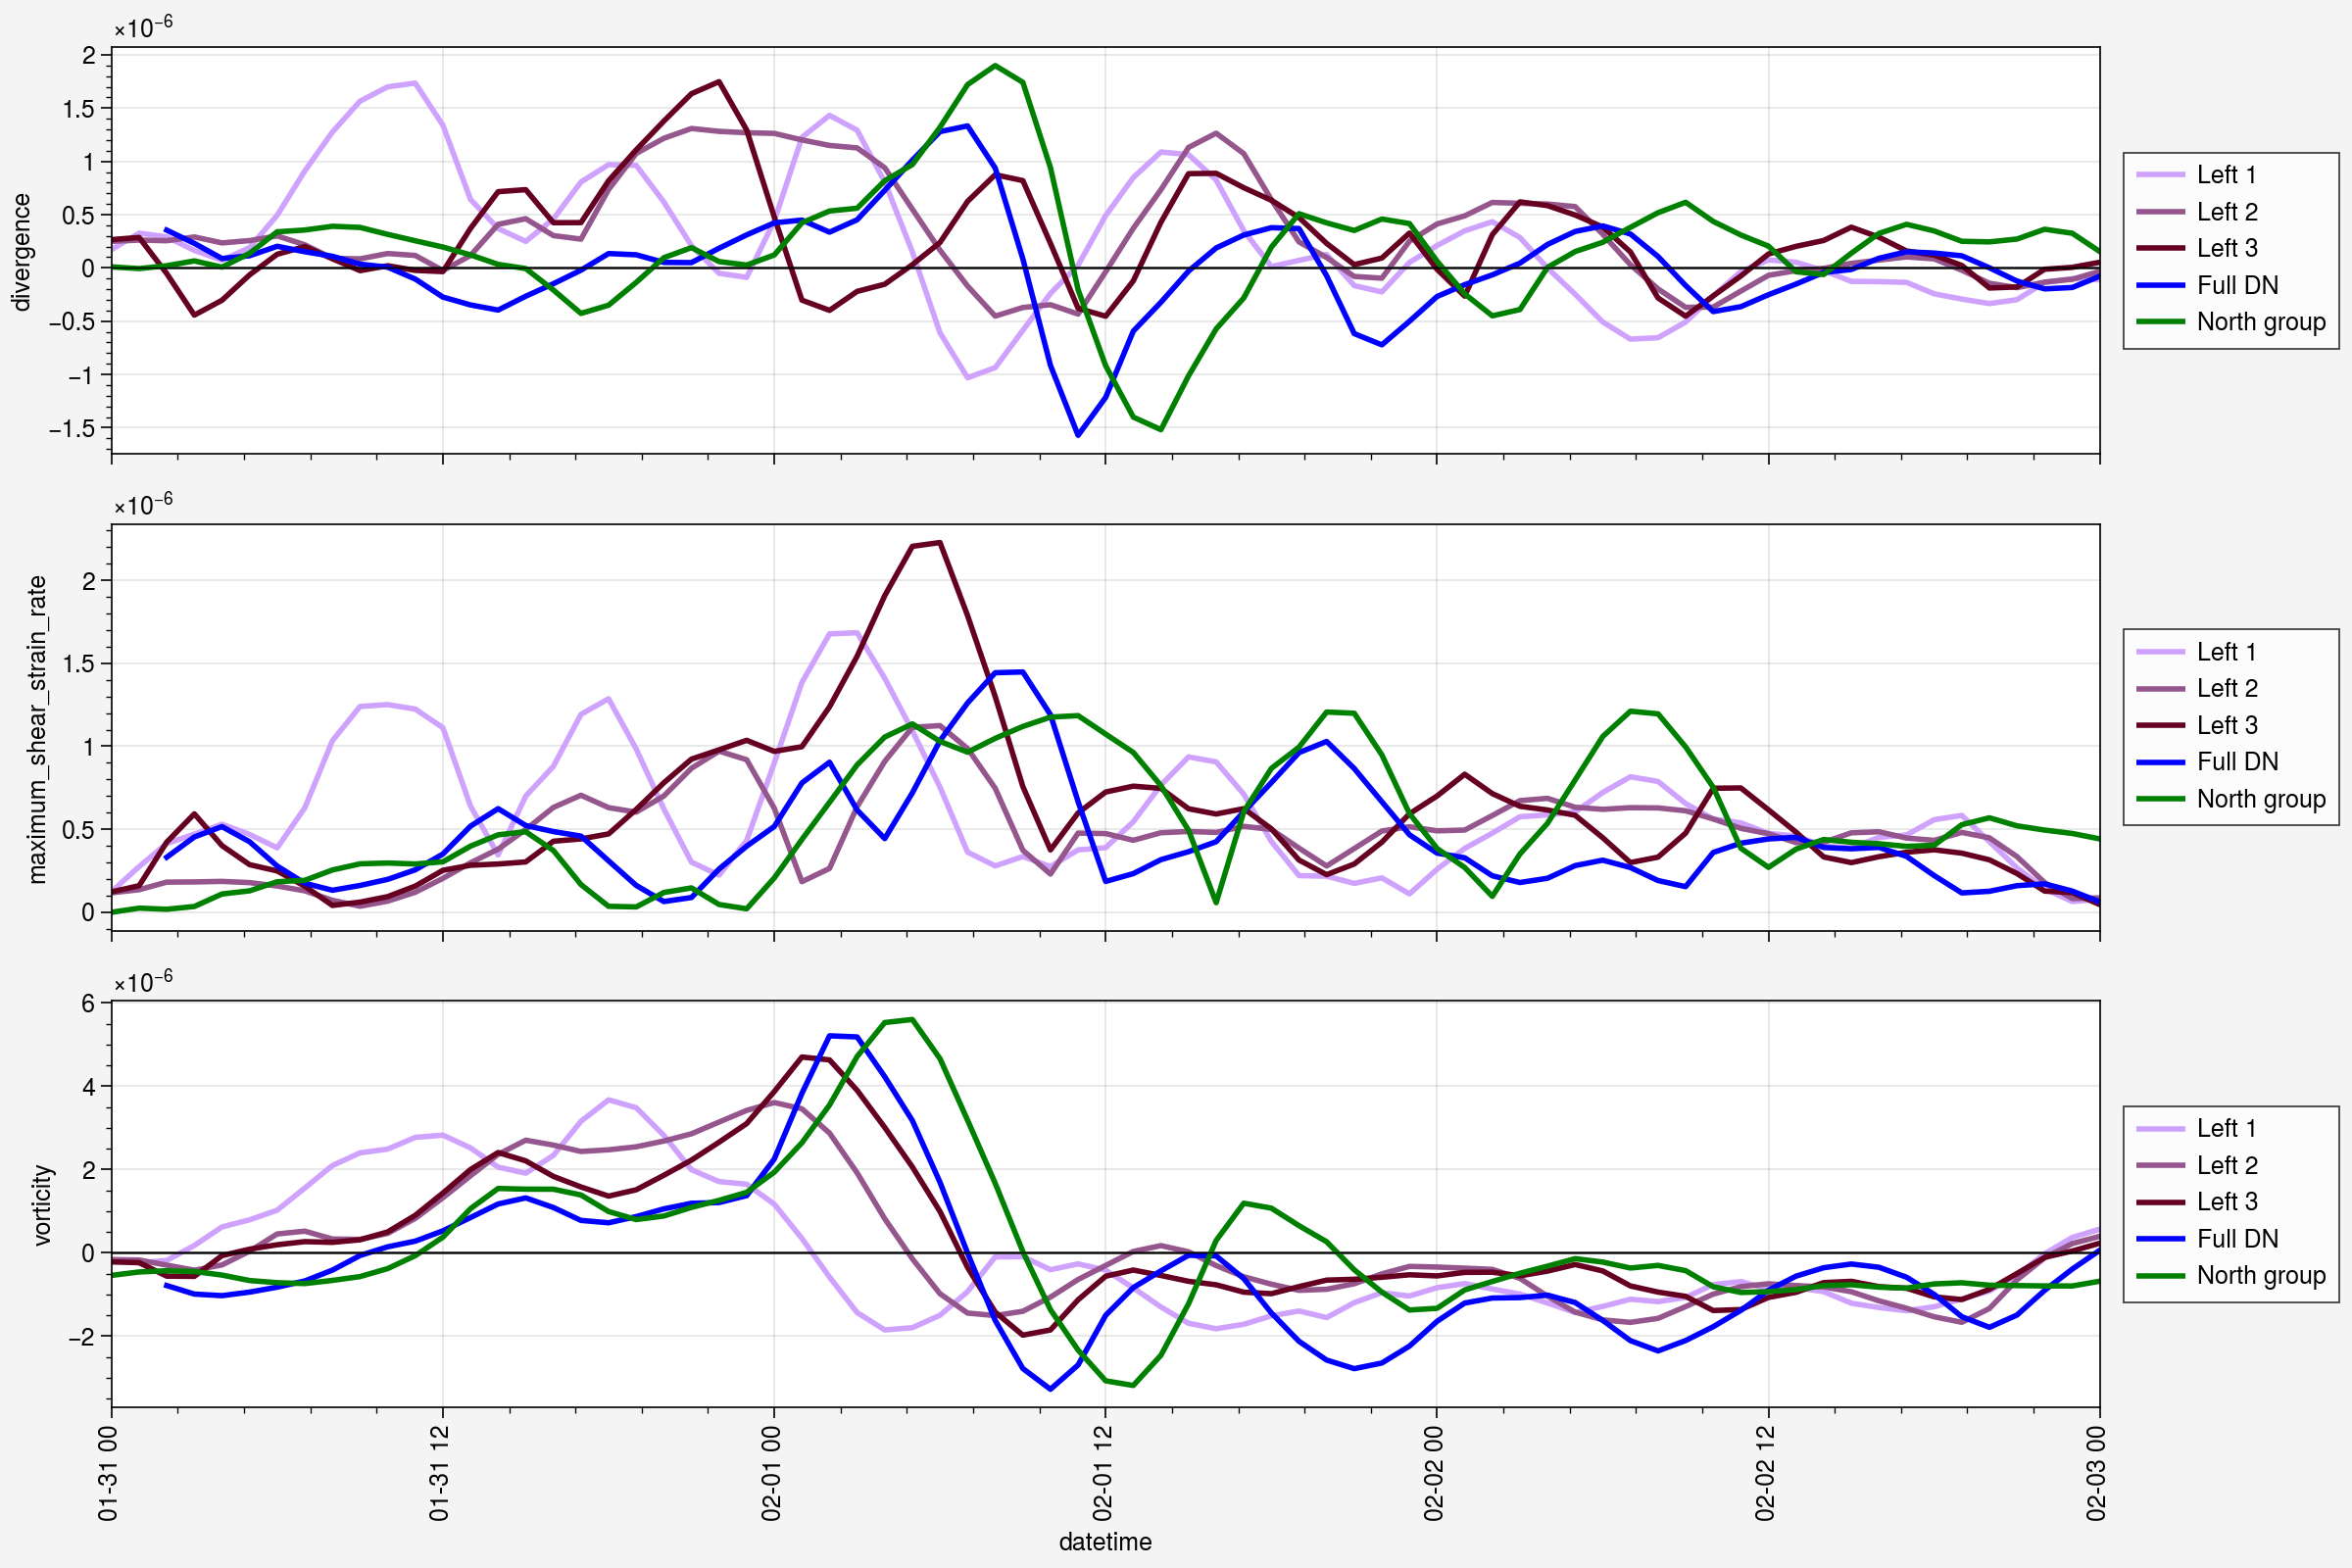

In [151]:
ts = slice('2020-01-31 00:00', '2020-02-03 00:00')
fig, ax = pplt.subplots(width=12, height=8, nrows=3, sharey=False)
for set_name in ['Left 1', 'Left 2', 'Left 3', 'Full DN', 'North group']:
    if set_name[0] == 'D':
        lw = 1
        label = ''
    else:
        lw = 2
        label = set_name
    ax[0].plot(strain_rates[set_name].divergence.loc[ts], color=colors[set_name], lw=lw, label=label)
    ax[1].plot(strain_rates[set_name].maximum_shear_strain_rate.loc[ts], color=colors[set_name], lw=lw, label=label)    
    ax[2].plot(strain_rates[set_name].vorticity.loc[ts], color=colors[set_name], lw=lw, label=label)        
    ax[0].axhline(0, color='k', lw=0.5) 
    ax[2].axhline(0, color='k', lw=0.5)     
ax.legend(loc='r', ncols=1)
fig.save('../figures/strain_rates_left.png', dpi=300)

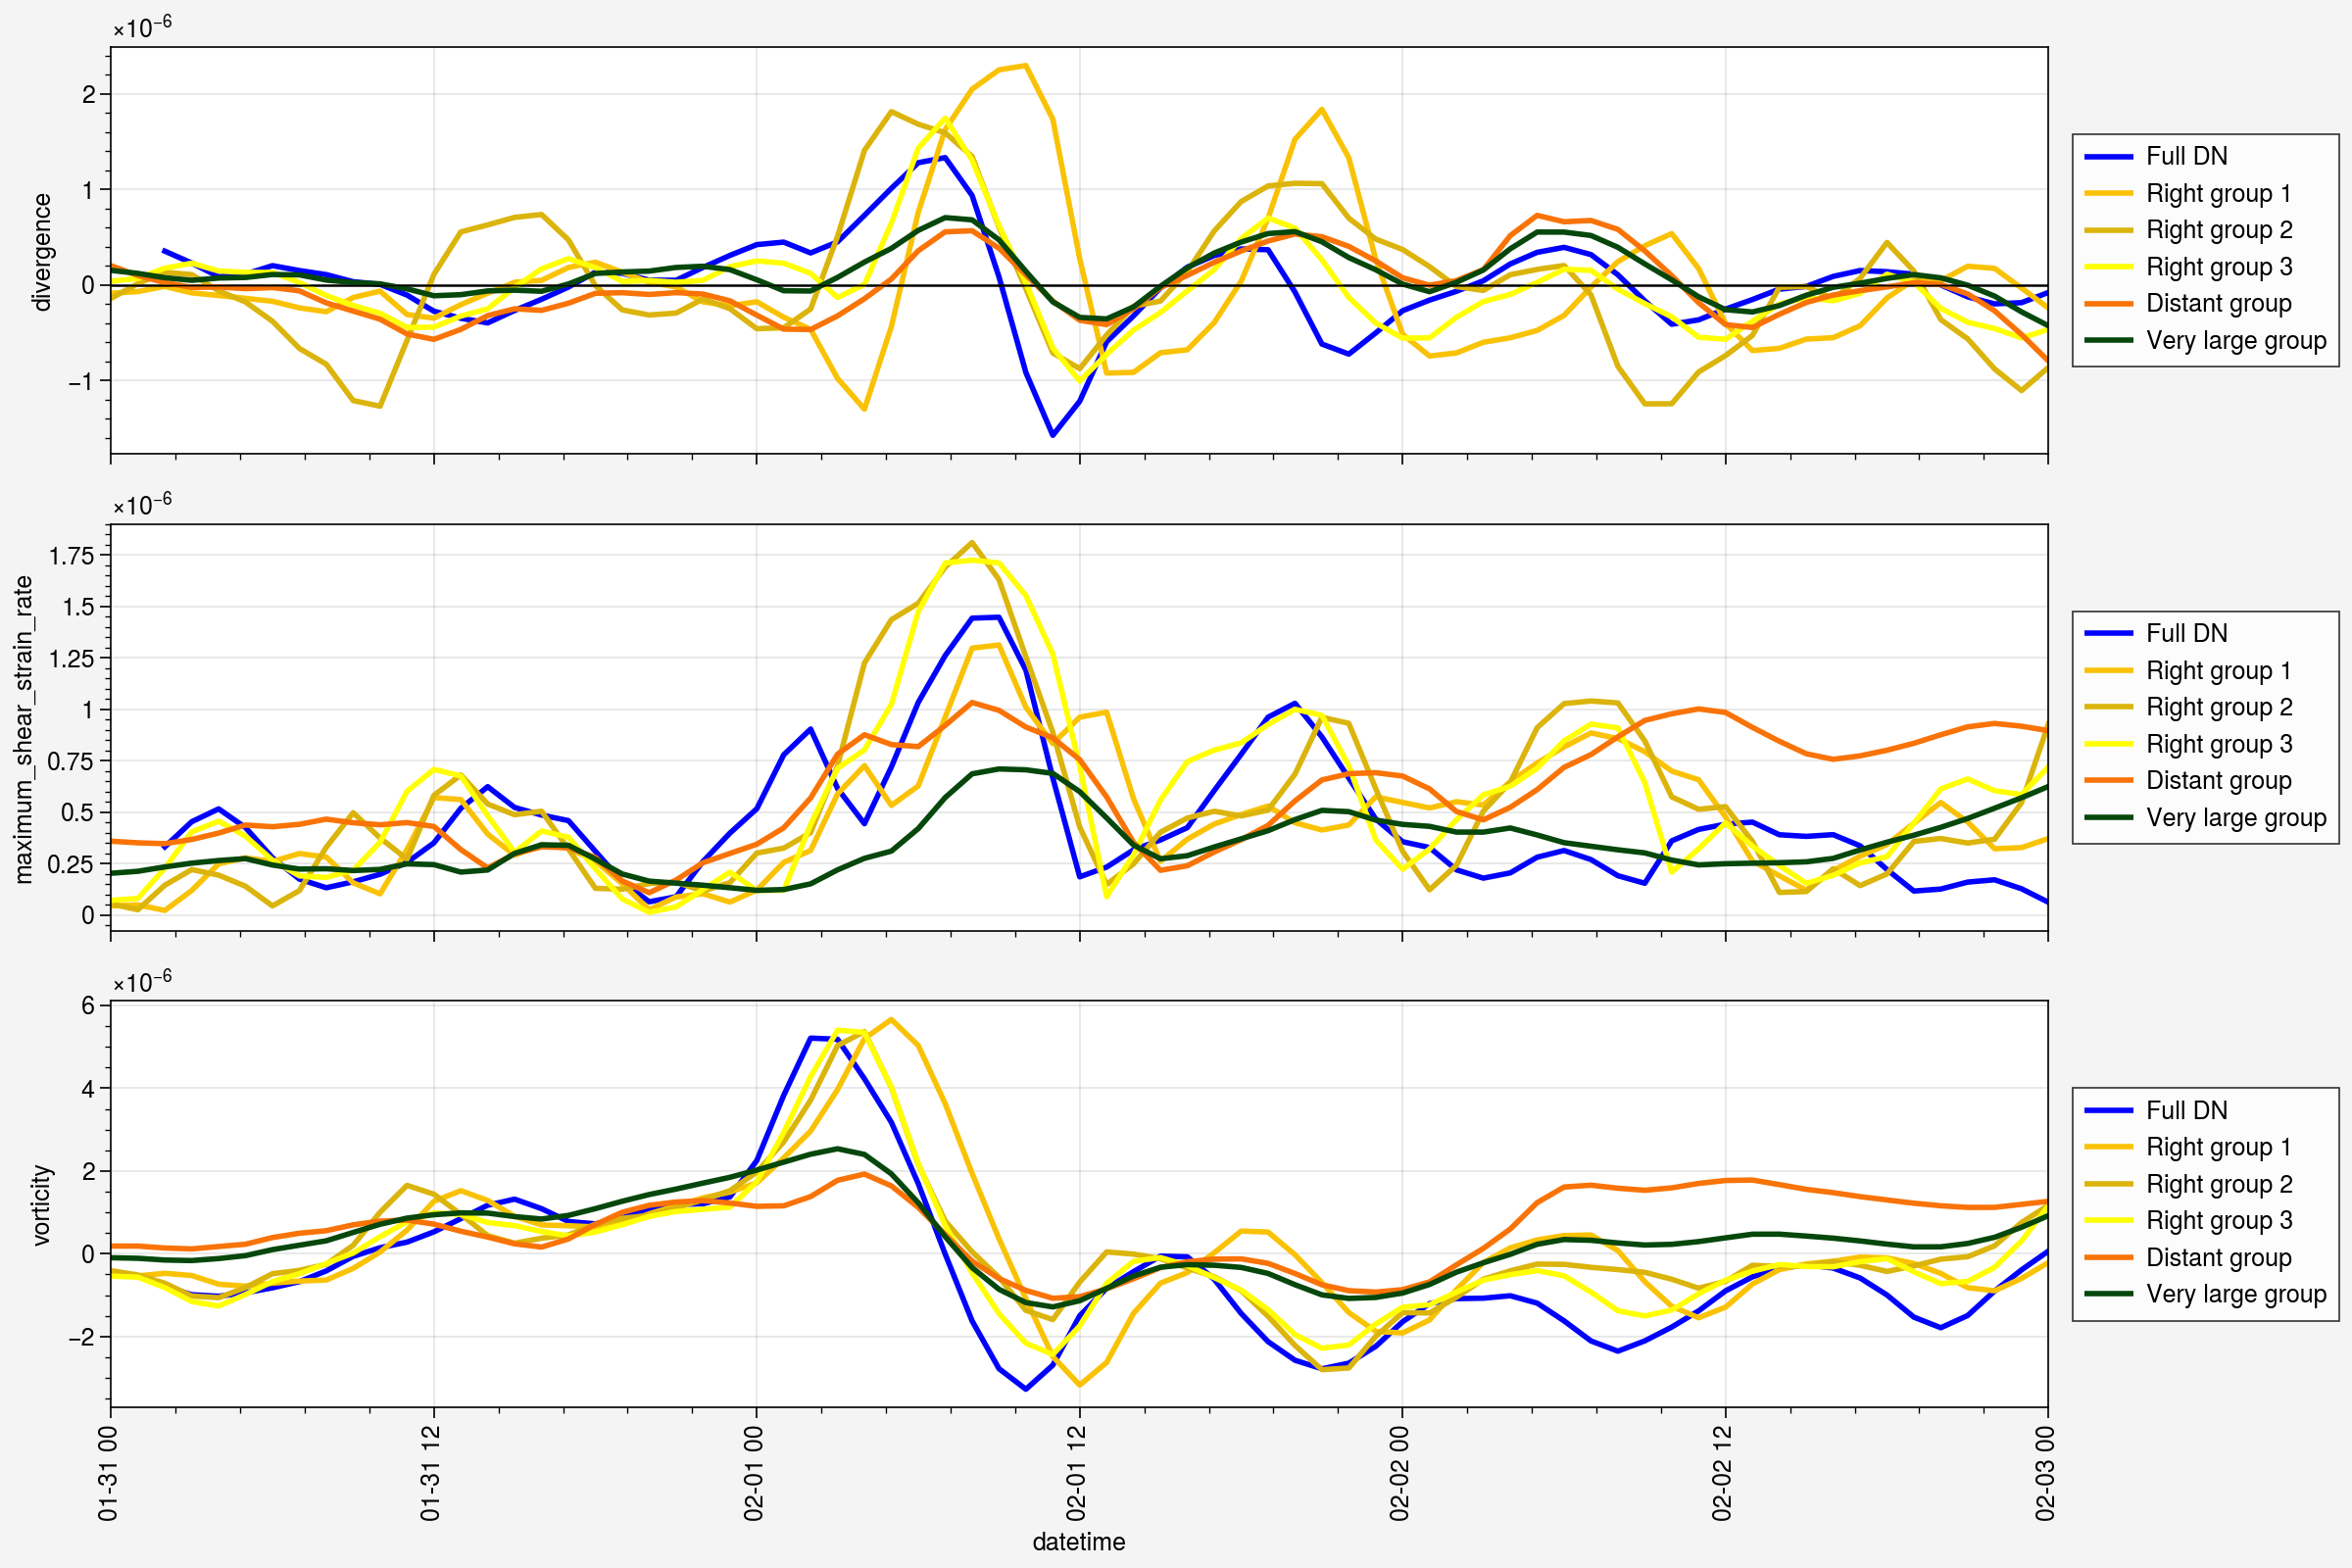

In [152]:
ts = slice('2020-01-31 00:00', '2020-02-03 00:00')
fig, ax = pplt.subplots(width=12, height=8, nrows=3, sharey=False)
for set_name in ['Full DN', 'Right group 1',
                 'Right group 2', 'Right group 3', 'Distant group', 'Very large group']:
    if set_name[0:2] == 'DN':
        lw = 1
        label = ''

    else:
        lw = 2
        label = set_name
    ax[0].plot(strain_rates[set_name].divergence.loc[ts], color=colors[set_name], lw=lw, label=label)
    ax[1].plot(strain_rates[set_name].maximum_shear_strain_rate.loc[ts], color=colors[set_name], lw=lw, label=label)    
    ax[2].plot(strain_rates[set_name].vorticity.loc[ts], color=colors[set_name], lw=lw, label=label)        
    ax[0].axhline(0, color='k', lw=0.5) 
ax.legend(loc='r', ncols=1)
fig.save('../figures/strain_rates_right.png', dpi=300)

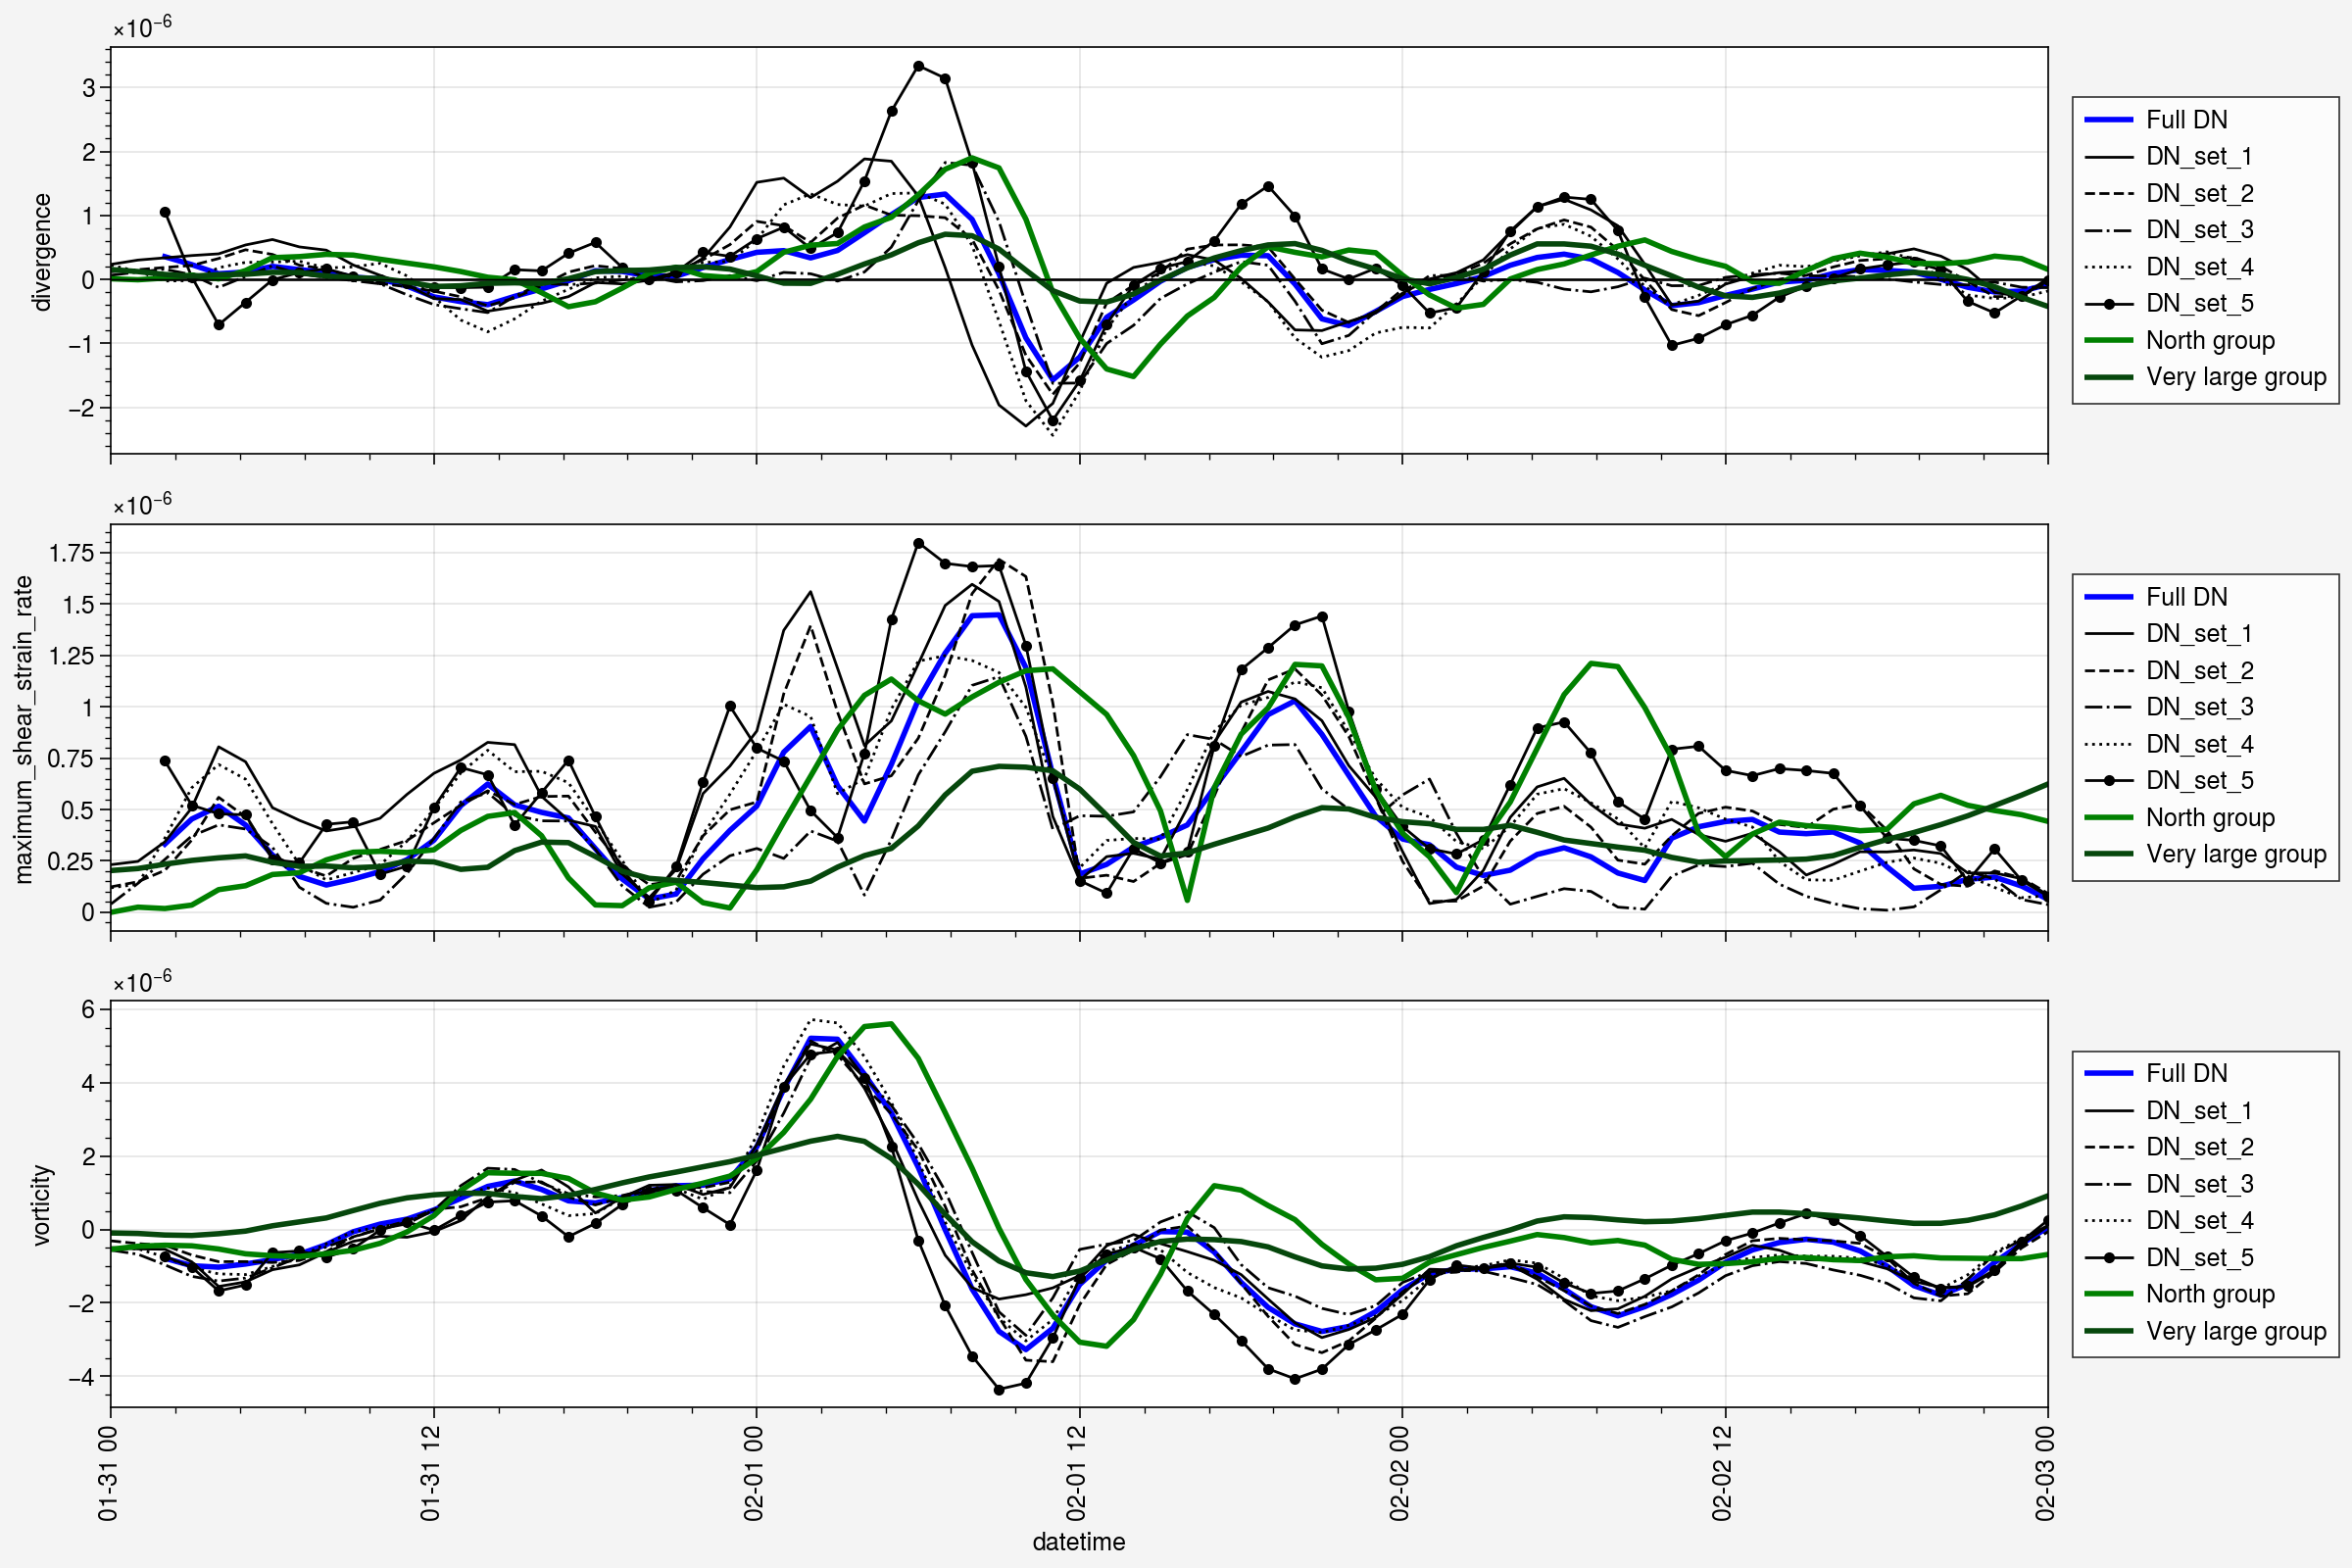

In [129]:
ts = slice('2020-01-31 00:00', '2020-02-03 00:00')
fig, ax = pplt.subplots(width=12, height=8, nrows=3, sharey=False)
lstyles = {'DN_set_1': '-',
      'DN_set_2': '--',
      'DN_set_3': '-.',
      'DN_set_4': ':',
      'DN_set_5': '-'}
for set_name in ['Full DN', 'DN_set_1', 'DN_set_2',
                 'DN_set_3', 'DN_set_4', 'DN_set_5', 'North group', 'Very large group']:
    if set_name[0:2] == 'DN':
        lw = 1
        label = set_name
        marker = ''
        ls = lstyles[set_name]
    else:
        lw = 2
        ls = '-'
        marker = ''
        label = set_name
    if set_name == 'DN_set_5':
        marker='.'
    ax[0].plot(strain_rates[set_name].divergence.loc[ts], color=colors[set_name], lw=lw, label=label, m=marker, ls=ls)
    ax[1].plot(strain_rates[set_name].maximum_shear_strain_rate.loc[ts], color=colors[set_name], lw=lw,  m=marker,label=label,  ls=ls)    
    ax[2].plot(strain_rates[set_name].vorticity.loc[ts], color=colors[set_name], lw=lw, label=label, m=marker, ls=ls)        
    ax[0].axhline(0, color='k', lw=0.5) 
ax.legend(loc='r', ncols=1)
fig.save('../figures/strain_rates_DN.png', dpi=300)

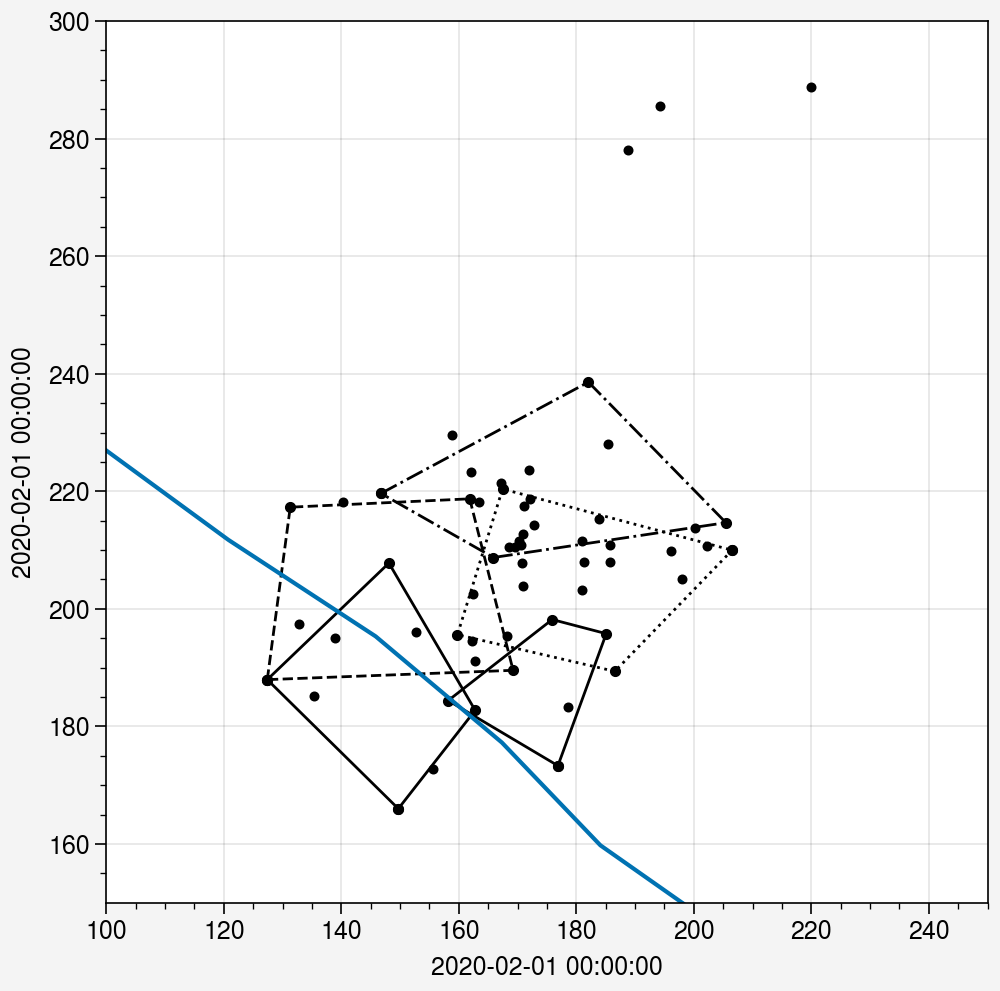

In [154]:
fig, ax = pplt.subplots(width=5)
date = '2020-02-01 00:00'
ax.scatter(df_x.loc[date, :],
           df_y.loc[date, :], marker='.', color='k', zorder=1)

for set_name in lstyles:
    buoy_set = polygons[set_name]
    ax.plot(df_x.loc[date, buoy_set + [buoy_set[0]]],
            df_y.loc[date, buoy_set + [buoy_set[0]]],
                label='', marker='.', ls=lstyles[set_name], lw=1, zorder=2, color=colors[set_name])
ax.plot(storm_track.loc[:, 'x_stere']/1e3, storm_track.loc[:, 'y_stere']/1e3)
ax.format(xreverse=False, ylim=(150, 300), xlim=(100, 250))
fig.save('../figures/polygon_reference_zoom.jpg', dpi=300)

longitude  latitude   center_mslp  lon_smoothed  \
2020-01-31 00:00:00    -174.00     84.50  99051.414062           NaN   
2020-01-31 01:00:00    -172.25     84.25  99060.859375           NaN   
2020-01-31 02:00:00       8.75     81.50  99038.023438         80.95   
2020-01-31 03:00:00      11.00     81.75  99020.117188         46.40   
2020-01-31 04:00:00      11.25     82.00  98956.140625         11.85   
...                        ...       ...           ...           ...   
2020-02-03 06:00:00    -163.25     78.75  98953.976562        196.50   
2020-02-03 07:00:00    -162.75     78.50  99050.429688        196.95   
2020-02-03 08:00:00    -162.75     78.50  99092.351562        197.25   
2020-02-03 09:00:00    -162.50     78.25  99158.882812           NaN   
2020-02-03 10:00:00    -162.50     78.00  99369.492188           NaN   

                     lat_smoothed  msl_smoothed       x_stere        y_stere  
2020-01-31 00:00:00           NaN           NaN           NaN            NaN  
2020-01-31 01:00:00           NaN           NaN           NaN            NaN  
2020-01-31 02:00:00         82.80  99025.310938  6.321967e+05  458475.383708  
2020-01-31 03:00:00         82.35  99002.439062  8.296398e+05   20275.960043  
2020-01-31 04:00:00         81.95  98970.906250  7.312590e+05 -477611.568397  
...                           ...           ...           ...            ...  
2020-02-03 06:00:00         78.70  98981.062500 -1.079118e+06  585913.538257  
2020-02-03 07:00:00         78.55  99039.207812 -1.098164e+06  585133.931105  
2020-02-03 08:00:00         78.40  99125.026563 -1.115733e+06  587015.736462  
2020-02-03 09:00:00           NaN           NaN           NaN            NaN  
2020-02-03 10:00:00           NaN           NaN           NaN            NaN  

[83 rows x 8 columns]

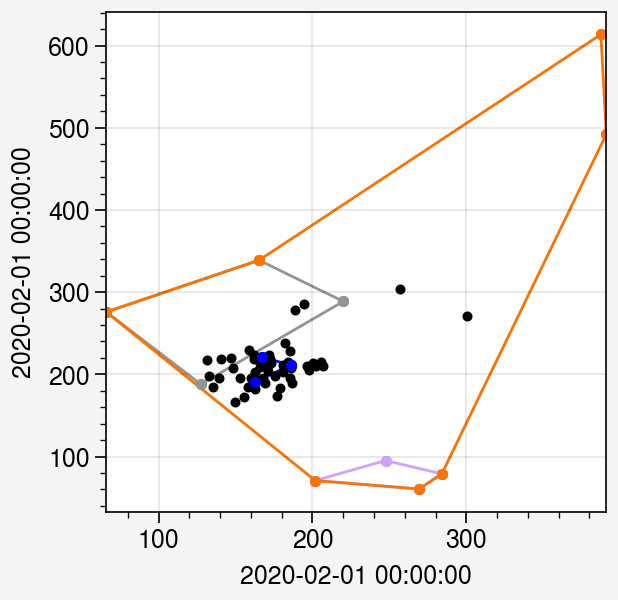

In [30]:
west_polygon = ['2019P182', '2019P127', '2019P184', '2019P128']
ahead_polygon = ['2019P22','2019P125', '2019P112', '2019P123']
l_polygon = ['2019T67', '2019T65', '2019S94']
large_polygon = ['2019P22', '2019P184', '2019P128', '2019P182', '2019P156',  '2019P157', '2019P123']
fig, ax = pplt.subplots()
date = '2020-02-01 00:00'
ax.scatter(df_x.loc[date, :],
           df_y.loc[date, :], marker='.', color='k', zorder=1)

for buoy_set, color in zip([west_polygon, l_polygon, ahead_polygon, large_polygon],
                           ['lilac', 'blue', 'gray', 'orange']):
    ax.plot(df_x.loc[date, buoy_set + [buoy_set[0]]],
            df_y.loc[date, buoy_set + [buoy_set[0]]],
                label='', marker='.', lw=1, color=color, zorder=0)
    for buoy in buoy_set:
        ax.plot(buoy_data[buoy].loc[date, 'x']/1e3,
                buoy_data[buoy].loc[date, 'y']/1e3,
                label=buoy, marker='.', color=color, lw=0, zorder=2)
ax.format(xreverse=False)
fig.save('../figures/polygon_reference.jpg', dpi=300)
#fig.legend(loc='b')

In [137]:
west_sr = anls.compute_strain_rate_components(west_polygon[::-1], buoy_data)
ahead_sr = anls.compute_strain_rate_components(ahead_polygon, buoy_data)
large_sr = anls.compute_strain_rate_components(large_polygon, buoy_data)

In [166]:
l_sr = anls.compute_strain_rate_components(l_polygon, buoy_data)

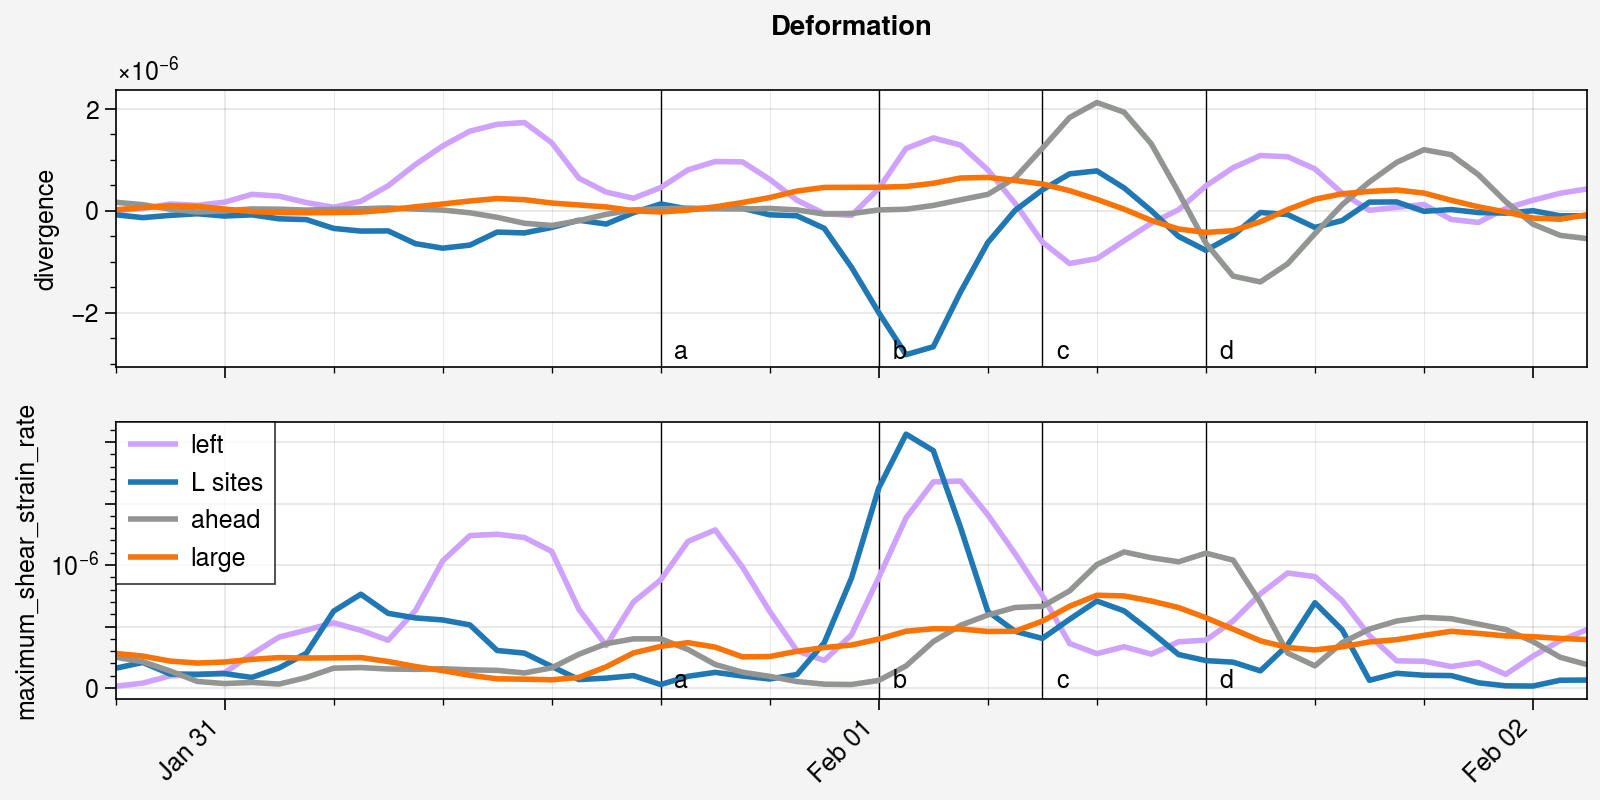

In [171]:

l_colors = {'2019T67': 'tab:blue',
            '2019T65': 'tab:red',
            '2019S94': 'tab:green'}


ts = slice('2020-01-30 20:00', '2020-02-02 02:00')
fig, axs = pplt.subplots(width=8, height=4, nrows=2, sharey=False)
for var, ax in zip(['divergence', 'maximum_shear_strain_rate', 'vorticity'], axs):

    ax.plot(west_sr.loc[ts, var], c='lilac', marker='', lw=2, label='left')
    ax.plot(l_sr.loc[ts, var], c='tab:blue', marker='', lw=2, label='L sites')
    ax.plot(ahead_sr.loc[ts, var], c='gray', marker='', lw=2, label='ahead')
    ax.plot(large_sr.loc[ts, var], c='orange', marker='', lw=2, label='large')

    ax.format(ylabel=var, xlabel='', xrotation=45, xformatter='%b %d',
             xlocator='day',
              xminorlocator=1/6, xgridminor=True, suptitle='Deformation')
ax.legend(loc='ul', ncols=1)    
zoom_plot_dates = ['2020-01-31 16:00', '2020-02-01 0:00', '2020-02-01 06:00', '2020-02-01 12:00']
zoom_plot_dates = [pd.to_datetime(x) for x in zoom_plot_dates]

ax.format(yformatter='log')
for abc, date in zip(['a', 'b', 'c', 'd'], zoom_plot_dates):
    for ax in axs:
        ax.axvline(date, color='k', lw=0.5, zorder=0)
    axs[0].text(date + pd.to_timedelta('30min'), -2.9e-6, abc, color='k', zorder=4)
    axs[1].text(date + pd.to_timedelta('30min'), 0, abc, color='k', zorder=4)
#     axs[2].text(date + pd.to_timedelta('30min'), 0, abc, color='k', zorder=4)
fig.save('../figures/deformation_polygons.jpg', dpi=300)

['2019P128', '2019P184', '2019P182', '2019P127']

In [108]:
for buoy in buoy_data:
    buoy_data[buoy] = anls.compute_along_across_components(buoy_data[buoy], 'u', 'v', 'u_mean', 'v_mean')

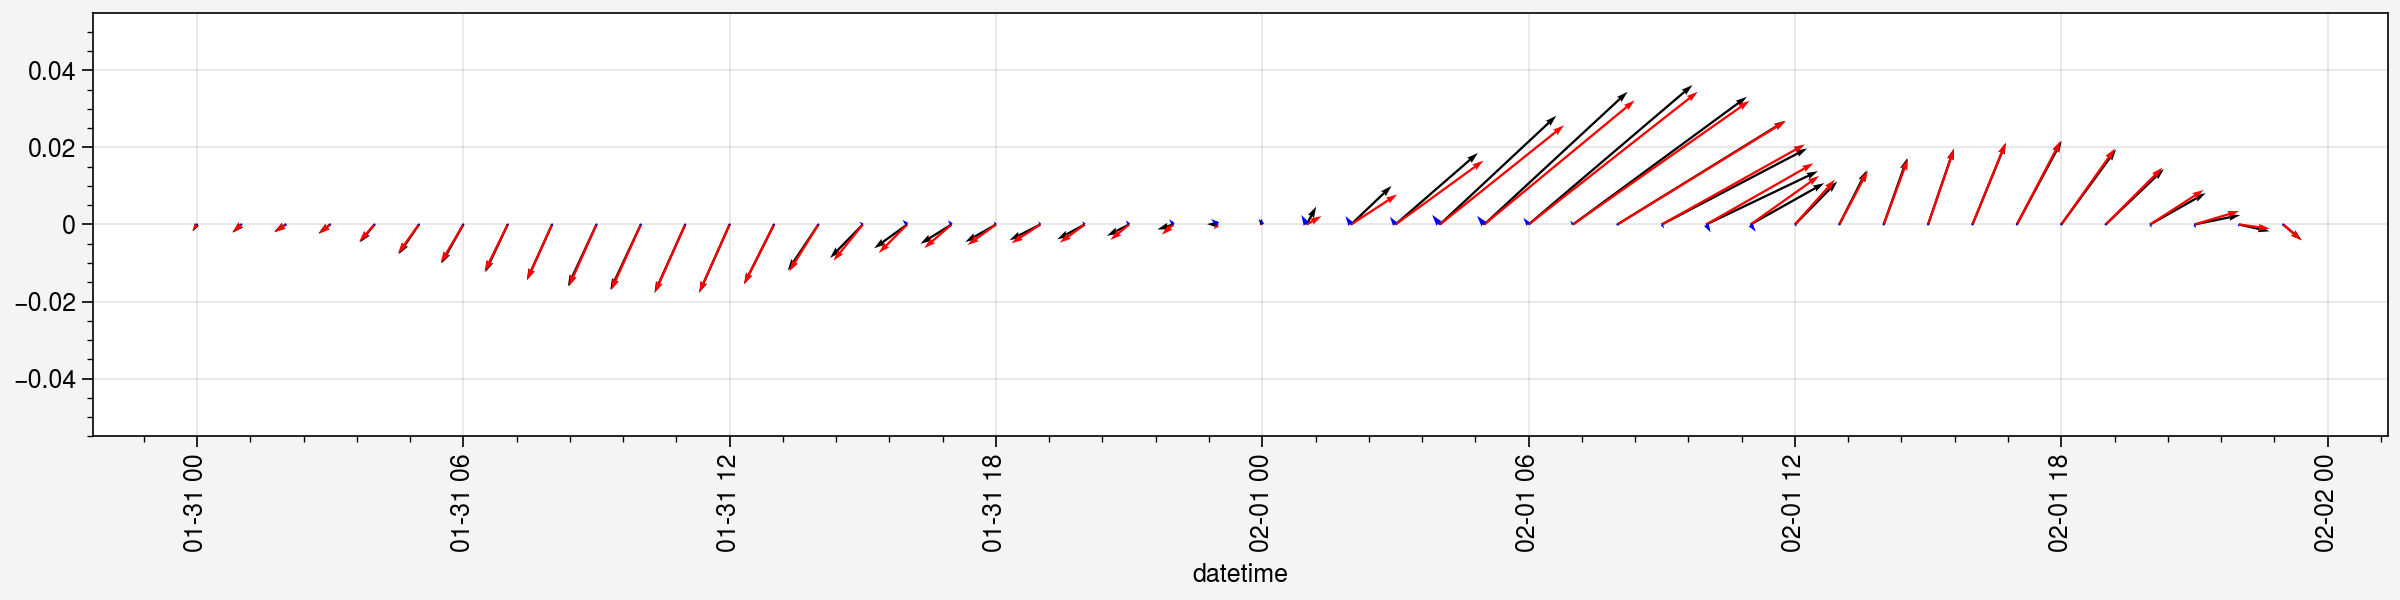

In [315]:
fig, ax = pplt.subplots(width=12, height=3)
df = buoy_data[l_sites[0]]
ts = slice('2020-01-31', '2020-02-01')
ax.quiver(df.u.loc[ts], df.v.loc[ts], width=1/1000, scale=5)
ax.quiver(df.u_along.loc[ts], df.v_along.loc[ts], width=1/1000, color='r', scale=5)
ax.quiver(df.u_across.loc[ts], df.v_across.loc[ts], width=1/1000, color='b', scale=5)

In [138]:

df_x.loc[date, l_sites], metadata.loc[l_sites, ['DN Station ID']]


(2019T67    204704.457112
 2019T65    186712.214627
 2019S94    179951.198559
 2019T66    188632.432482
 Name: 2020-01-25 00:00:00, dtype: float64,
           DN Station ID
 Sensor ID              
 2019T67              L1
 2019T65              L2
 2019S94              L3
 2019T66              LM)

In [ ]:
# idea: make animation that shows the position along the track as it moves along.
# potentially also showing the wind direction and speed

In [142]:
idx = 0
ts = slice('2020-01-25', '2020-02-05')
for date in df_x.loc[ts].index:
    fig, ax = pplt.subplots(width=4)
    x0 = df_x.loc[date].median()
    y0 = df_y.loc[date].median()

    ax.scatter(df_x.loc[date] - x0, df_y.loc[date]-y0, s=5)
    ax.quiver(df_x.loc[date] - x0, df_y.loc[date]-y0,
              df_u_along.loc[date] - df_u_mean.loc[date], df_v_along.loc[date] - df_v_mean.loc[date], width=1/250, scale=1/2, c='r')
    ax.quiver(df_x.loc[date] - x0, df_y.loc[date]-y0,
              df_u_across.loc[date], df_v_across.loc[date], width=1/250, scale=1/2, c='b')


    ax.quiver(0, 0,  df_u_mean.loc[date].mean(), df_v_mean.loc[date].mean(), width=1/250, scale=1/2, color='k')


    # Indicate L sites
    for site, color in zip(l_sites, ['tab:blue', 'tab:red', 'tab:green']):
        if metadata.loc[site, 'DN Station ID'] != 'LM':
            ax.text(df_x.loc[date, site] - x0, df_y.loc[date, site] - y0,
                text=metadata.loc[site, 'DN Station ID'],
                bbox=True, color='w',
                fontsize=7,
                bboxcolor=color,
                bboxstyle='square', bboxalpha=1, zorder=10)
    ax.format(ylim=(-6e4, 6e4), xlim=(-6e4, 6e4), title=date, ylabel='y', xlabel='x')
    fig.save('../frames/' + 'frame' + str(idx).zfill(4) + '.jpg')
    pplt.close(fig)
    idx += 1

In [143]:
name = 'jan_feb_anom_vel_labels' + '.mp4'
folder = '../frames/'
! ffmpeg -r 12 -f image2 -s 1920x1080 -i $folder/frame%04d.jpg -vcodec libx264 -crf 25  -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2" -pix_fmt yuv420p $name 

ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 14.0.0 (clang-1400.0.29.202)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/5.1.2_5 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack

frame=  288 fps= 33 q=-1.0 Lsize=    4701kB time=00:00:23.75 bitrate=1621.4kbits/s speed=2.73x    
video:4697kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.087786%
[libx264 @ 0x14f6075e0] frame I:2     Avg QP: 9.54  size:107379
[libx264 @ 0x14f6075e0] frame P:91    Avg QP:25.75  size: 27519
[libx264 @ 0x14f6075e0] frame B:195   Avg QP:30.82  size: 10717
[libx264 @ 0x14f6075e0] consecutive B-frames:  7.3%  4.2%  9.4% 79.2%
[libx264 @ 0x14f6075e0] mb I  I16..4: 74.2% 21.2%  4.6%
[libx264 @ 0x14f6075e0] mb P  I16..4:  0.3%  0.7%  0.5%  P16..4:  1.5%  0.5%  0.4%  0.0%  0.0%    skip:96.0%
[libx264 @ 0x14f6075e0] mb B  I16..4:  0.1%  0.1%  0.1%  B16..8:  1.7%  0.4%  0.2%  direct: 0.1%  skip:97.4%  L0:51.4% L1:44.3% BI: 4.2%
[libx264 @ 0x14f6075e0] 8x8 transform intra:32.7% inter:21.5%
[libx264 @ 0x14f6075e0] coded y,uvDC,uvAC intra: 11.1% 15.2% 14.5% inter: 0.3% 0.6% 0.6%
[libx264 @ 0x14f6075e0] i16 v,h,dc,p: 82% 17%  1%  0%
[libx264 @ 0x14f6075e0] i8 v,h,d

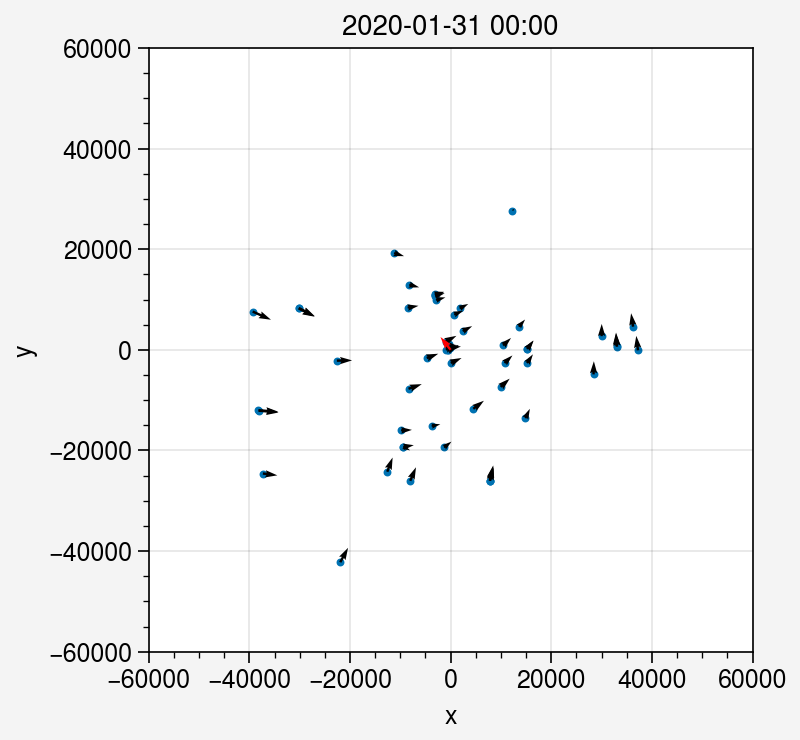

In [193]:
date = '2020-01-31 00:00'
fig, ax = pplt.subplots(width=4)
x0 = df_x.loc[date].median()
y0 = df_y.loc[date].median()

ax.scatter(df_x.loc[date] - x0, df_y.loc[date]-y0, s=5)
ax.quiver(df_x.loc[date] - x0, df_y.loc[date]-y0,
          df_u.loc[date]-df_u.mean(axis=1).loc[date],
          df_v.loc[date]-df_v.mean(axis=1).loc[date],
          width=1/250, scale=1/2)
ax.quiver(0, 0,  df_u.mean(axis=1).loc[date], df_v.mean(axis=1).loc[date],
          width=1/250, scale=1/2, color='r')
ax.format(ylim=(-6e4, 6e4), xlim=(-6e4, 6e4), title=date, ylabel='y', xlabel='x')

(array([ 6., 10., 10., 18.,  5.,  3.,  4.,  1.,  1.,  1.,  1.,  0.,  1.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.]),
 array([0.        , 0.00344828, 0.00689655, 0.01034483, 0.0137931 ,
        0.01724138, 0.02068966, 0.02413793, 0.02758621, 0.03103448,
        0.03448276, 0.03793103, 0.04137931, 0.04482759, 0.04827586,
        0.05172414, 0.05517241, 0.05862069, 0.06206897, 0.06551724,
        0.06896552, 0.07241379, 0.07586207, 0.07931034, 0.08275862,
        0.0862069 , 0.08965517, 0.09310345, 0.09655172, 0.1       ]),
 <BarContainer object of 29 artists>)

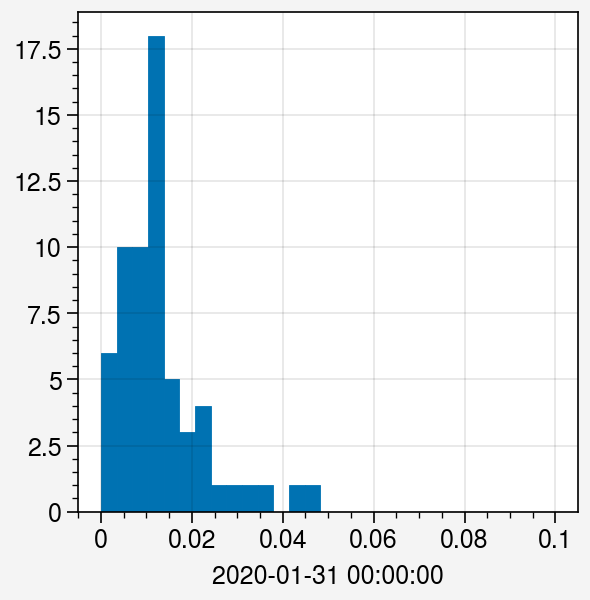

In [208]:
fig,ax = pplt.subplots()
ax.hist(norm.dropna(), bins=np.linspace(0, 0.1, 30))

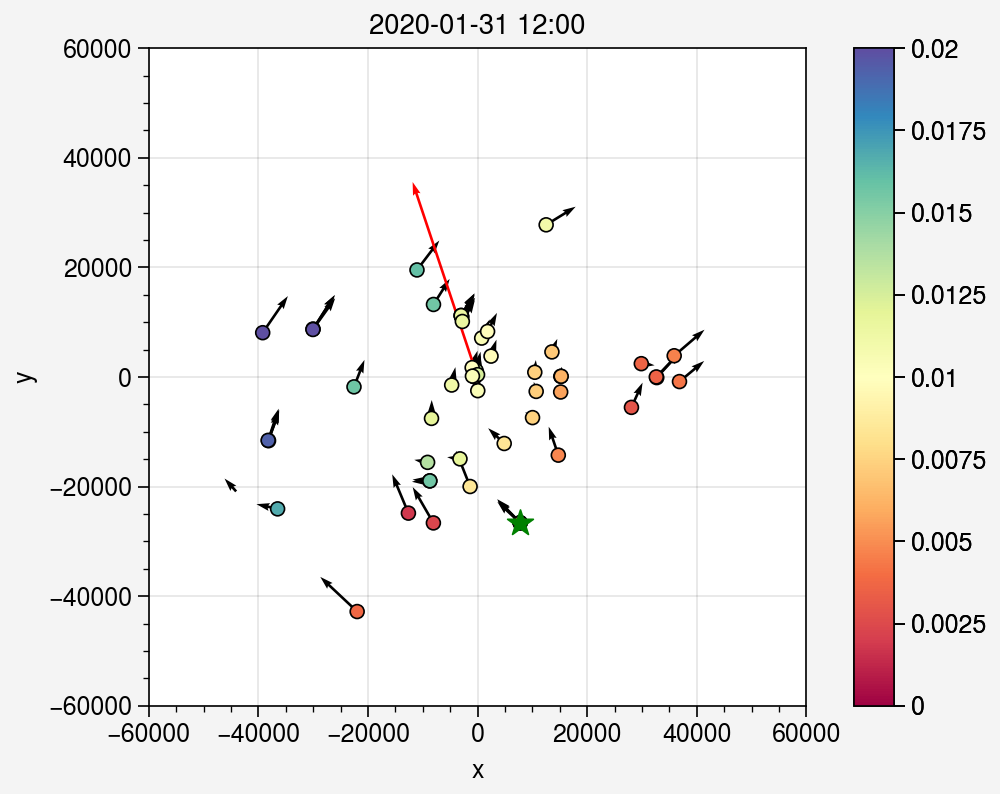

In [216]:
comp = '2019T64'
del_u = (df_u.T - df_u[comp]).T
del_v = (df_v.T - df_v[comp]).T
norm = np.sqrt(del_u.loc[date]**2 + del_v.loc[date]**2)

date = '2020-01-31 12:00'
fig, ax = pplt.subplots(width=5)
x0 = df_x.loc[date].median()
y0 = df_y.loc[date].median()

ax.scatter(df_x.loc[date] - x0, df_y.loc[date]-y0, s=25, c=norm,
           cmap='spectral', zorder=3, colorbar='r', vmax=0.02, edgecolor='k')
ax.quiver(df_x.loc[date] - x0, df_y.loc[date]-y0,
          df_u.loc[date]-df_u.mean(axis=1).loc[date],
          df_v.loc[date]-df_v.mean(axis=1).loc[date],
          width=1/250, scale=1/2)
ax.quiver(0, 0,  df_u.mean(axis=1).loc[date], df_v.mean(axis=1).loc[date],
          width=1/250, scale=1/2, color='r')
ax.scatter(df_x.loc[date, comp] - x0, df_y.loc[date, comp]-y0, s=95,
           zorder=15, marker='*', color='green')


ax.format(ylim=(-6e4, 6e4), xlim=(-6e4, 6e4), title=date, ylabel='y', xlabel='x')

Clustering idea
We specify a threshold in angle and magnitue. 

In [259]:
size_thresh = 0.025
ang_thresh = 0.2
all_buoys = list(df_u.loc[date].dropna().index)
group_id = 0
group_ids = []
assigned = []
for buoy in all_buoys:
    if buoy not in assigned:
        del_u = df_u.loc[date] - df_u.loc[date, comp]
        del_v = df_v.loc[date] - df_v.loc[date, comp]
        diff_df = pd.DataFrame({'del_u': del_u,
                                'del_v': del_v}).dropna()
        diff_df['norm'] = np.abs(diff_df['del_u'] + 1j*diff_df['del_v'])
        diff_df['angle'] = np.angle(diff_df['del_u'] + 1j*diff_df['del_v'])
        group = diff_df.loc[(diff_df.norm < size_thresh) & (np.abs(diff_df.angle) < ang_thresh)]
        for b in group.index:
            if b not in assigned:
                assigned.append(b)
                group_ids.append(group_id)
        group_id += 1

already assigned 2019P158
already assigned 2019P201
already assigned 2019P199
already assigned 2019P151


/var/folders/ll/n11_xyw94n53r6mpnl4p0bqh0000gn/T/ipykernel_5900/408634644.py:12: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  df_labels['x'] = df_x.loc[date, buoys] - x0


ValueError: cannot reindex on an axis with duplicate labels

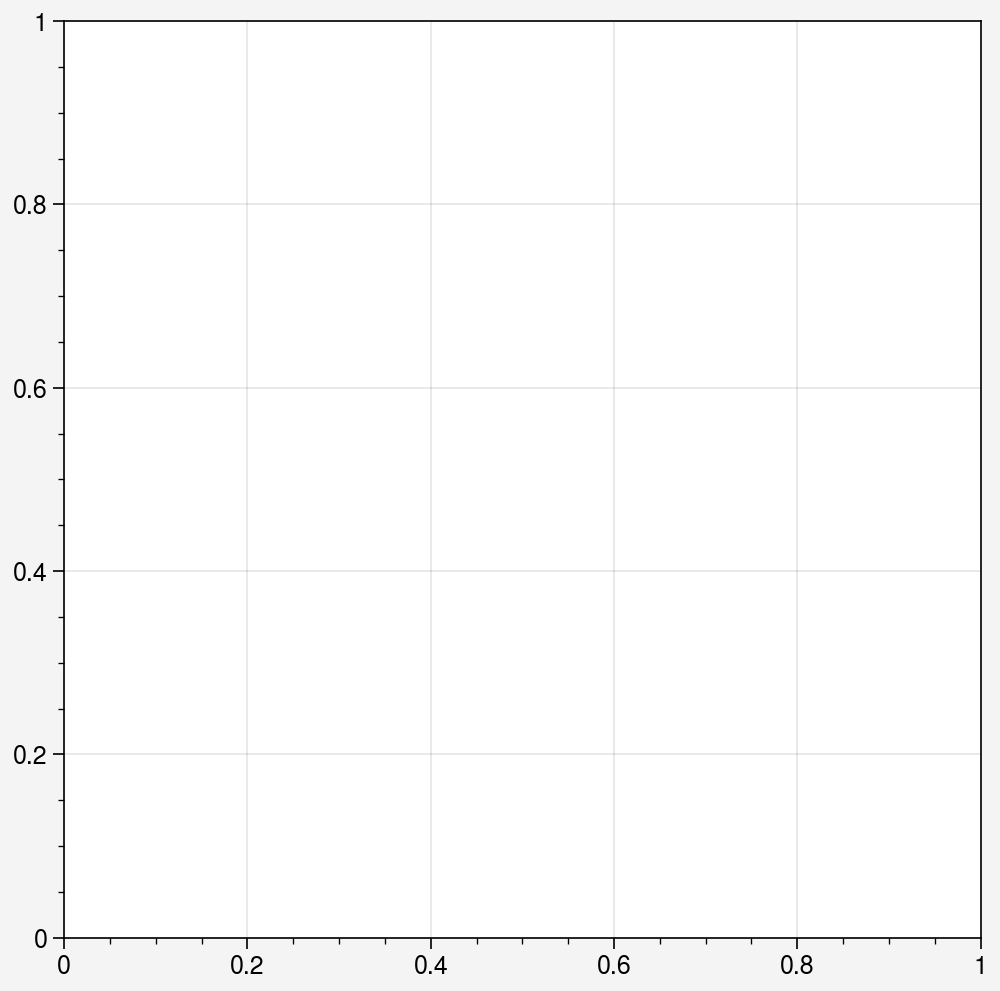

In [251]:
df_labels = pd.DataFrame({'buoy': assigned, 'id': group_ids})
comp = '2019T64'
del_u = (df_u.T - df_u[comp]).T
del_v = (df_v.T - df_v[comp]).T
norm = np.sqrt(del_u.loc[date]**2 + del_v.loc[date]**2)

date = '2020-01-31 12:00'
fig, ax = pplt.subplots(width=5)
x0 = df_x.loc[date].median()
y0 = df_y.loc[date].median()
buoys = df_labels.buoy
df_labels['x'] = df_x.loc[date, buoys] - x0
df_labels['y'] = df_y.loc[date, buoys] - y0
for name, group in df_labels.groupby('id'):
    ax.scatter(group['x'], group['y'], s=25)
#ax.scatter(df_x.loc[date, buoys] - x0, df_y.loc[date, buoys]-y0, s=25, c=df_labels.id,
#           cmap='spectral', zorder=3, colorbar='r', vmax=70, edgecolor='k')
ax.quiver(df_x.loc[date] - x0, df_y.loc[date]-y0,
          df_u.loc[date]-df_u.mean(axis=1).loc[date],
          df_v.loc[date]-df_v.mean(axis=1).loc[date],
          width=1/250, scale=1/2)
ax.quiver(0, 0,  df_u.mean(axis=1).loc[date], df_v.mean(axis=1).loc[date],
          width=1/250, scale=1/2, color='r')
ax.scatter(df_x.loc[date, comp] - x0, df_y.loc[date, comp]-y0, s=95,
           zorder=15, marker='*', color='green')


ax.format(ylim=(-6e4, 6e4), xlim=(-6e4, 6e4), title=date, ylabel='y', xlabel='x')

In [33]:
df_x = pd.DataFrame({b: buoy_data[b]['x'] for b in ['2019S93', '2019R9']})
df_y = pd.DataFrame({b: buoy_data[b]['y'] for b in ['2019S93', '2019R9']})

In [39]:
dist = np.sqrt((df_x['2019S93'] - df_x.shift(1)['2019R9'])**2 +\
               (df_y['2019S93'] - df_y.shift(1)['2019R9'])**2)

In [53]:
dataloc = '../../MOSAiC/Data/DN_positions_v2/'
l2_sites = {f.split('_')[-1].replace('.csv', ''):
            pd.read_csv(dataloc + f, index_col='datetime', parse_dates=True) for
            f in os.listdir(dataloc) if f[:2] == 'L2'}

In [57]:
for site in l2_sites:
    anls.compute_speed(l2_sites[site], date_index=True, rotate_uv=True, difference='centered')

# Theoretical response to storm
If we assume that the ice relation to the wind is fixed (or consider just the wind component of ice motion), we have ice velocity that adjusts to wind speed following
$$ U_{ice} = A\exp^{i\theta}U_{wind} + \epsilon $$

I generate a pressure low using a Gaussian function, so the strongest gradient is partway across the low and the gradient is smooth at the center. Next, I generate a geostrophic wind field.


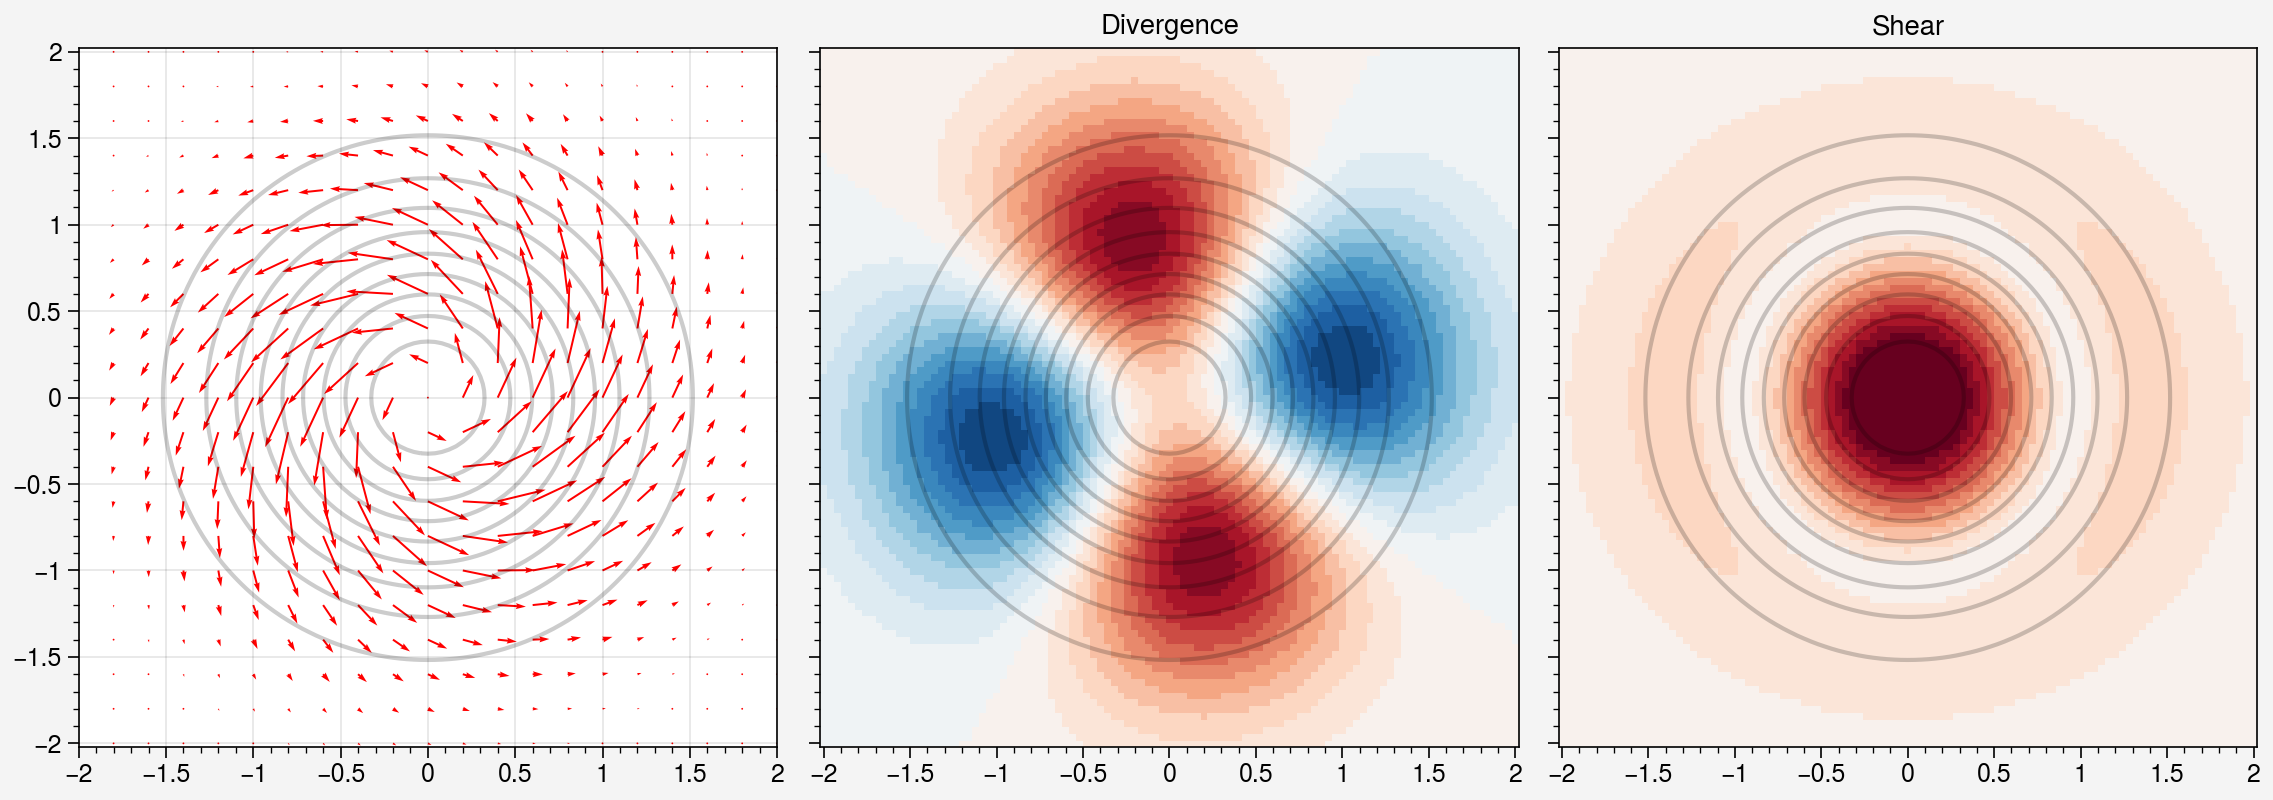

In [220]:
alpha = 1
theta = 25

f = 1e-4
x = np.linspace(-2, 2, 101)
y = np.linspace(-2, 2, 101)
X, Y = np.meshgrid(x, y)
C = np.diag(np.ones(101))
P = 1000 - 20*np.exp(-(X**2 + Y**2))
P = P*100
dPdx = 20*2*X*np.exp(-(X**2 + Y**2))
dPdy = 20*2*Y*np.exp(-(X**2 + Y**2))
rho = 1.2 # Replace later for thermal wind component

u = - 1/(f*rho)*dPdy
v = 1/f*dPdx

uice = alpha*np.exp(-1j*np.deg2rad(theta))*(u + 1j*v)
u_ice = np.real(uice)
v_ice = np.imag(uice)
dudx_ice, dudy_ice = np.gradient(u_ice)
dvdx_ice, dvdy_ice = np.gradient(v_ice)
div = dudx_ice + dvdy_ice
tot_shear = 1/2*np.sqrt((dudx_ice - dvdy_ice)**2 + (dudy_ice + dvdx_ice)**2)

fig, axs = pplt.subplots(height=4, ncols=3)
for ax in axs:
    ax.contour(X, Y, P, color='k', alpha=0.2)

#axs[0].quiver(X[::5,::5], Y[::5,::5], u[::5,::5], v[::5,::5])
axs[0].quiver(X[::5,::5], Y[::5,::5], u_ice[::5,::5], v_ice[::5,::5], c='r')
axs[1].pcolormesh(X, Y, div, vmin=dudx_ice.min(), vmax=-dudx_ice.min(), N=30)
axs[2].pcolormesh(X, Y, tot_shear, vmin=dudx_ice.min(), vmax=-dudx_ice.min(), N=30)
axs[1].format(title='Divergence')
axs[2].format(title='Shear')

In this idealized case where we only are looking at free drift, instantaneously. The examples given by Clancy et al. are composites of the change from 5 days before and 5 days after. Furthermore this is just the geostrophic wind component. The real wind isn't fully geostrophic in a cyclone.

moving forward, if we were to take the era5 winds alone, what would the snapshot look like? and what would be the time series look like for a parcel in each storm sector?


In [198]:
dudx_ice.max()

7033.9073970265235